##  Desenvolvimento de Modelos de Predição do IPCA da Indústria de Transformação a Partir de Proxy para o Custo de Produção da Indústria de Transformação e Outros Indicadores

## Modelos em Redes Neurais Artificiais

A previsão do IPCA de Bens Industriais é realizada considerando os seguintes indicadores como variáveis exógenas:

IPA - para cálculo da Proxy do Custo de Produção da Indústria de Transformação;

IC-Br (Índice de Commodities);

IBC-Br (Índice de Atividade Econômica)

PIM-PF (Produção da Indústria Brasileira)

ICI (Índice de Confiança da Indústria) - contempla as desagregações: NUCI (Nível de Utilização da Capacidade Instalada) e Nível de Estoques

Consumo Aparente da Indústria de Transformação

Consumo de Energia Elétrica da Indústria

In [1]:
#Biblioteca para acessar e interagir com APIs e páginas da web
import requests 

# Bibliotecas para dados:
import pandas as pd
import numpy as np

#Biblioteca para criação de gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Bibliotecas de tratamento de estatistico de séries e de manipulação de datas e horários:

from statsmodels.tsa.seasonal import seasonal_decompose

from dateutil.parser import parse

In [3]:
#Biblioteca para Análise de Estacionariedade por Teste de ADF

from statsmodels.tsa.stattools import adfuller

In [4]:
# Biblioteca para Geração de Gráfico de Função de Autocorrelação e Autocorrelação Parcial

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.graphics.tsaplots import plot_pacf

In [5]:
#Bibliotecas para métricas de avaliação de modelos:

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_percentage_error

from sklearn.metrics import r2_score

from sklearn.metrics import root_mean_squared_error


In [6]:
# Bibilotecas para Normalização de Dados:

from sklearn.preprocessing import MinMaxScaler

In [7]:
# Biblioteca para conversão de data:

from datetime import datetime

In [8]:
# Biblioteca para GridSearch e TimeSeriesSplit para Cross Validation

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit

In [9]:
#Bibliotecas para Validação

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score

In [10]:
# Biblioteca para Análise de Componentes Principais (PCA):

from sklearn.decomposition import PCA

In [11]:
# Bibliotecas necessárias para o modelo de redes neurais:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf

In [12]:
# Mais bibliotecas para modelos de redes neurais

from tensorflow.keras.layers import LSTM, GRU, Dropout

In [13]:
# Biblioteca para salvar e carregar modelos treinados

import joblib
import os

### Carregamento dos Dados em Formato csv

In [14]:
# Carregamento de Dados a partir de um arquivo CSV:

df_base1 = pd.read_csv('Dados/Base Completa/base_dados_2005.csv')
df_base1.head()

,Mes,Proxy - Custo Prod Ind Transf Var Mensal%,Ind Transf Sem Ajuste Sazonal Var Men (%),ICI,Nivel de estoques,NUCI,IBC-BR Variacao Mensal (%),IC - Composto Var Men (%),Consumo Aparente - Var Mensal,Consumo E. Eletrica Ind Var Mensal %,IPCA Bens Ind Var Mensal %
0,2005-01-31,0.250514,-4.469845,106.8,94.8,84.3,-3.756043,-0.315489,-3.616918,-5.533154,0.61
1,2005-02-28,0.409522,-5.588296,106.6,92.8,83.9,0.463679,-2.739591,-7.151135,0.758833,0.39
2,2005-03-31,0.754040,15.371508,103.5,91.6,83.4,10.980769,8.623144,16.362902,2.494705,0.35
3,2005-04-30,0.790196,-1.486933,102.1,90.7,82.2,-2.659851,-6.515634,-1.624174,2.365098,0.93
4,2005-05-31,-0.343708,4.662271,99.8,90.1,81.5,-1.326213,-6.629281,5.064549,-0.613130,0.75


In [15]:
df_base1

,Mes,Proxy - Custo Prod Ind Transf Var Mensal%,Ind Transf Sem Ajuste Sazonal Var Men (%),ICI,Nivel de estoques,NUCI,IBC-BR Variacao Mensal (%),IC - Composto Var Men (%),Consumo Aparente - Var Mensal,Consumo E. Eletrica Ind Var Mensal %,IPCA Bens Ind Var Mensal %
0,2005-01-31,0.250514,-4.469845,106.8,94.8,84.3,-3.756043,-0.315489,-3.616918,-5.533154,0.61
1,2005-02-28,0.409522,-5.588296,106.6,92.8,83.9,0.463679,-2.739591,-7.151135,0.758833,0.39
2,2005-03-31,0.754040,15.371508,103.5,91.6,83.4,10.980769,8.623144,16.362902,2.494705,0.35
3,2005-04-30,0.790196,-1.486933,102.1,90.7,82.2,-2.659851,-6.515634,-1.624174,2.365098,0.93
4,2005-05-31,-0.343708,4.662271,99.8,90.1,81.5,-1.326213,-6.629281,5.064549,-0.613130,0.75
...,...,...,...,...,...,...,...,...,...,...,...
235,2024-08-31,0.607579,1.384228,101.5,96.2,83.2,-1.342374,-2.305761,1.948814,3.082151,0.17
236,2024-09-30,0.775323,-3.341286,100.4,96.0,83.4,-2.664307,1.638534,-3.735931,-2.168758,0.16
237,2024-10-31,0.638631,4.040392,99.9,94.5,82.5,2.037204,4.610222,4.818552,-0.212816,0.26
238,2024-11-30,0.857047,-8.813216,99.1,95.5,81.7,-3.414003,3.900330,-12.924405,-0.225118,0.19


In [16]:
## Convertendo a data para formato datetime

df_base1['Mes'] = pd.to_datetime(df_base1['Mes'])


In [17]:
df_base1

,Mes,Proxy - Custo Prod Ind Transf Var Mensal%,Ind Transf Sem Ajuste Sazonal Var Men (%),ICI,Nivel de estoques,NUCI,IBC-BR Variacao Mensal (%),IC - Composto Var Men (%),Consumo Aparente - Var Mensal,Consumo E. Eletrica Ind Var Mensal %,IPCA Bens Ind Var Mensal %
0,2005-01-31,0.250514,-4.469845,106.8,94.8,84.3,-3.756043,-0.315489,-3.616918,-5.533154,0.61
1,2005-02-28,0.409522,-5.588296,106.6,92.8,83.9,0.463679,-2.739591,-7.151135,0.758833,0.39
2,2005-03-31,0.754040,15.371508,103.5,91.6,83.4,10.980769,8.623144,16.362902,2.494705,0.35
3,2005-04-30,0.790196,-1.486933,102.1,90.7,82.2,-2.659851,-6.515634,-1.624174,2.365098,0.93
4,2005-05-31,-0.343708,4.662271,99.8,90.1,81.5,-1.326213,-6.629281,5.064549,-0.613130,0.75
...,...,...,...,...,...,...,...,...,...,...,...
235,2024-08-31,0.607579,1.384228,101.5,96.2,83.2,-1.342374,-2.305761,1.948814,3.082151,0.17
236,2024-09-30,0.775323,-3.341286,100.4,96.0,83.4,-2.664307,1.638534,-3.735931,-2.168758,0.16
237,2024-10-31,0.638631,4.040392,99.9,94.5,82.5,2.037204,4.610222,4.818552,-0.212816,0.26
238,2024-11-30,0.857047,-8.813216,99.1,95.5,81.7,-3.414003,3.900330,-12.924405,-0.225118,0.19


## Criação de Variável Dummy para Regime de Exceção

Uma variável dummy para o período da pandemia e início da Guerra da Ucrânia foi criada para representar esse período de exceção no qual as regras normais não se aplicam. Ambos os eventos foram choques exógenos que impactaram a economia.

Para identificação do período do regime de exceção, veja o gráfico a seguir:

In [18]:
#Conversão da coluna Mes para índice do dataframe para o dataframe df_base1

df_base2 = df_base1.copy()
df_base2 = df_base2.set_index('Mes')

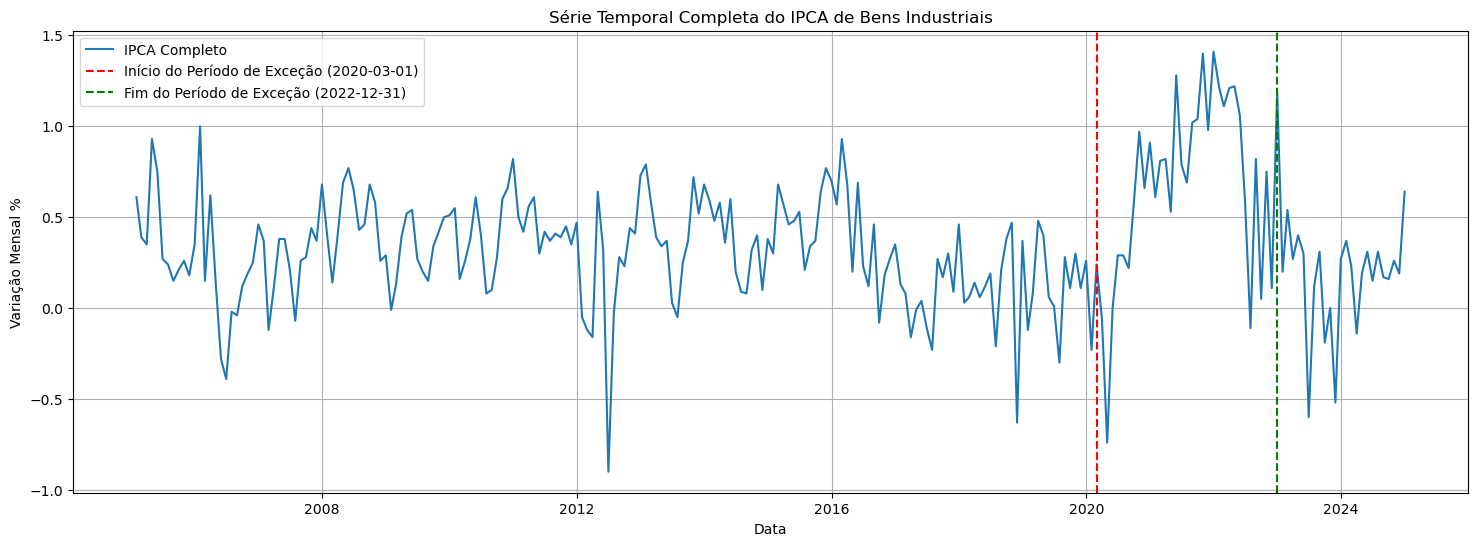

In [19]:
# Gráfico para visão geral
plt.figure(figsize=(18, 6))

# Plotagem da série inteira
plt.plot(df_base2.index, df_base2['IPCA Bens Ind Var Mensal %'], label='IPCA Completo')

# Encontrando a data de início da pandemia até final do período de início da guerra na Ucrânia
data_inicio = '2020-03-01'
data_fim = '2022-12-31'
data_inicio_dt = pd.to_datetime(data_inicio)
plt.axvline(data_inicio_dt, color='red', linestyle='--', label=f'Início do Período de Exceção ({data_inicio})')

data_fim_dt = pd.to_datetime(data_fim)
plt.axvline(data_fim_dt, color='green', linestyle='--', label=f'Fim do Período de Exceção ({data_fim})')

plt.title('Série Temporal Completa do IPCA de Bens Industriais')
plt.xlabel('Data')
plt.ylabel('Variação Mensal %')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Conversão da coluna Mes para índice do dataframe para o dataframe df_base1:

df_base1 = df_base1.set_index('Mes')

In [21]:
# Criação de Variável Dummy para Regime de Exceção

# 1. Definição das datas de início e fim
data_inicio = '2020-03-01'
data_fim = '2022-12-31'

# 2. Criar a coluna com o nome mais abrangente e inicializar com 0
df_base1['regime_excecao'] = 0

# 3. Selecionar o intervalo e definir o valor como 1
df_base1.loc[(df_base1.index >= data_inicio) & (df_base1.index <= data_fim), 'regime_excecao'] = 1

# 4. Verificar
print(df_base1['regime_excecao'].value_counts())

regime_excecao
0    206
1     34
Name: count, dtype: int64


In [22]:
df_base1

,Proxy - Custo Prod Ind Transf Var Mensal%,Ind Transf Sem Ajuste Sazonal Var Men (%),ICI,Nivel de estoques,NUCI,IBC-BR Variacao Mensal (%),IC - Composto Var Men (%),Consumo Aparente - Var Mensal,Consumo E. Eletrica Ind Var Mensal %,IPCA Bens Ind Var Mensal %,regime_excecao
Mes,,,,,,,,,,,
2005-01-31,0.250514,-4.469845,106.8,94.8,84.3,-3.756043,-0.315489,-3.616918,-5.533154,0.61,0
2005-02-28,0.409522,-5.588296,106.6,92.8,83.9,0.463679,-2.739591,-7.151135,0.758833,0.39,0
2005-03-31,0.754040,15.371508,103.5,91.6,83.4,10.980769,8.623144,16.362902,2.494705,0.35,0
2005-04-30,0.790196,-1.486933,102.1,90.7,82.2,-2.659851,-6.515634,-1.624174,2.365098,0.93,0
2005-05-31,-0.343708,4.662271,99.8,90.1,81.5,-1.326213,-6.629281,5.064549,-0.613130,0.75,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.607579,1.384228,101.5,96.2,83.2,-1.342374,-2.305761,1.948814,3.082151,0.17,0
2024-09-30,0.775323,-3.341286,100.4,96.0,83.4,-2.664307,1.638534,-3.735931,-2.168758,0.16,0
2024-10-31,0.638631,4.040392,99.9,94.5,82.5,2.037204,4.610222,4.818552,-0.212816,0.26,0


## Atenção:

As observações das séries da bas de dados serão defasados para considerar a endogeneidade da série do IPCA de bens industriais e que variações, por exemplo, no custo de produção em determinado período t, são percebidas no IPCA de bens industriais t+n períodos a frente.

A endogeneidade diz respeito ao valor do IPCA em t depender de seus valores passados.

Consideraremos uma defasagem de 4 meses para todas as variáveis.

In [23]:
# --- CRIAÇÃO DE FEATURES DEFASADAS  ---

# 1. Criação um novo DataFrame para as features
# Usamos o índice do df_base1 para garantir o alinhamento de datas
df_tabular = pd.DataFrame(index=df_base1.index)

# 2. Listando todas as colunas que serão usadas como base para as features defasadas
# Inclui: variável alvo, exógenas e as dummies
features_para_defasar = [
    'IPCA Bens Ind Var Mensal %',
    'Proxy - Custo Prod Ind Transf Var Mensal%',
    'Ind Transf Sem Ajuste Sazonal Var Men (%)',
    'Nivel de estoques',
    'IBC-BR Variacao Mensal (%)',
    'Consumo Aparente - Var Mensal',
    'Consumo E. Eletrica Ind Var Mensal %',
    'regime_excecao'
]

# 3. Definindo quantos meses para trás serão considerados (lags)
n_lags = 4

# 4. Loop para criar todas as colunas defasadas
for col in features_para_defasar:
    for i in range(1, n_lags + 1):
        # Criando uma nova coluna com o nome da feature e o lag
        df_tabular[f'{col}_lag_{i}'] = df_base1[col].shift(i)

# 5. Adicionando a variável alvo final que se deseja prever (sem defasagem)
df_tabular['target_IPCA_bensind'] = df_base1['IPCA Bens Ind Var Mensal %']

# 6. Remoção das linhas com valores NaN que foram criadas no início pelos shifts
df_tabular.dropna(inplace=True)

# 7. Verificando o resultado
print("Shape do novo DataFrame tabular:", df_tabular.shape)
print("\nAlgumas das novas colunas de features:")
print(df_tabular.head())

Shape do novo DataFrame tabular: (236, 33)

Algumas das novas colunas de features:
            IPCA Bens Ind Var Mensal %_lag_1  \
Mes                                            
2005-05-31                              0.93   
2005-06-30                              0.75   
2005-07-31                              0.27   
2005-08-31                              0.24   
2005-09-30                              0.15   

            IPCA Bens Ind Var Mensal %_lag_2  \
Mes                                            
2005-05-31                              0.35   
2005-06-30                              0.93   
2005-07-31                              0.75   
2005-08-31                              0.27   
2005-09-30                              0.24   

            IPCA Bens Ind Var Mensal %_lag_3  \
Mes                                            
2005-05-31                              0.39   
2005-06-30                              0.35   
2005-07-31                              0.93   
200

### Criação de Base de Dados para Treinamento e Teste

80% dos dados para treinamento (na sequência cronológica) / 20% dos dados para teste.

In [24]:
# Divisão da base de dados em base de dados de treinamento e teste:

# (Usando o ponto de corte de 80% para treinamento e 20% para teste)

ponto_corte = int(len(df_tabular) * 0.8)

print(ponto_corte)

188


In [25]:
# Criação da base de dados de treinamento
df_base_trein = df_tabular.iloc[:ponto_corte].copy()

# Criação da base de dados de teste

df_base_teste = df_tabular.iloc[ponto_corte:].copy()

In [26]:
# Remoção dos NaNs do conjunto de treino:

df_base_trein.dropna(inplace=True)

In [27]:
# Checando o resultado para a base de treino
print("--- Informações da Base de Treino com Índice de Data ---")
print(df_base_trein.info())
print(df_base_trein.head())


--- Informações da Base de Treino com Índice de Data ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2005-05-31 to 2020-12-31
Data columns (total 33 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   IPCA Bens Ind Var Mensal %_lag_1                 188 non-null    float64
 1   IPCA Bens Ind Var Mensal %_lag_2                 188 non-null    float64
 2   IPCA Bens Ind Var Mensal %_lag_3                 188 non-null    float64
 3   IPCA Bens Ind Var Mensal %_lag_4                 188 non-null    float64
 4   Proxy - Custo Prod Ind Transf Var Mensal%_lag_1  188 non-null    float64
 5   Proxy - Custo Prod Ind Transf Var Mensal%_lag_2  188 non-null    float64
 6   Proxy - Custo Prod Ind Transf Var Mensal%_lag_3  188 non-null    float64
 7   Proxy - Custo Prod Ind Transf Var Mensal%_lag_4  188 non-null    float64
 8   Ind Transf Sem Ajuste Sazonal Var 

In [28]:
# Checando o resultado para a base de teste
print("--- Informações da Base de Teste com Índice de Data ---")
print(df_base_teste.info())
print(df_base_teste.head())

--- Informações da Base de Teste com Índice de Data ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2021-01-31 to 2024-12-31
Data columns (total 33 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   IPCA Bens Ind Var Mensal %_lag_1                 48 non-null     float64
 1   IPCA Bens Ind Var Mensal %_lag_2                 48 non-null     float64
 2   IPCA Bens Ind Var Mensal %_lag_3                 48 non-null     float64
 3   IPCA Bens Ind Var Mensal %_lag_4                 48 non-null     float64
 4   Proxy - Custo Prod Ind Transf Var Mensal%_lag_1  48 non-null     float64
 5   Proxy - Custo Prod Ind Transf Var Mensal%_lag_2  48 non-null     float64
 6   Proxy - Custo Prod Ind Transf Var Mensal%_lag_3  48 non-null     float64
 7   Proxy - Custo Prod Ind Transf Var Mensal%_lag_4  48 non-null     float64
 8   Ind Transf Sem Ajuste Sazonal Var Me

### Função para Avaliação de Performance dos Modelos

In [29]:
#Função para avaliação do modelo:

def aval_modelo(y_teste, y_pred):
    mse = mean_squared_error(y_teste, y_pred)
    rmse = root_mean_squared_error(y_teste, y_pred)
    mape = mean_absolute_percentage_error(y_teste, y_pred)
    r2_modelo = r2_score(y_teste, y_pred)
    neg_mae = -mean_absolute_error(y_teste, y_pred)
    
    print(f'\nRaiz do Erro Quadrático Médio do Modelo: {rmse:.2f}')
    print(f'\nErro Quadrático Médio do Modelo: {mse:.2f}')
    print(f'\nErro Absoluto Médio NEGATIVO do Modelo: {neg_mae:.2f}')
    print(f'\nErro Percentual Absoluto Médio: {mape:.2f}')
    print(f'\nR^2 do Modelo: {r2_modelo:.2f}')
    print('\n')
    print("Para Erro Absoluto Médio NEGATIVO, vale a convenção de quanto maior melhor, deve-se escolher o modelo que apresenta maior valor de erro absoluto médio negativo.")
    print('\n')
    print("Para modelos obtidos por machine learning e redes neurais não se deve considerar o R^2")

In [30]:
df_base_trein.columns

Index(['IPCA Bens Ind Var Mensal %_lag_1', 'IPCA Bens Ind Var Mensal %_lag_2',
       'IPCA Bens Ind Var Mensal %_lag_3', 'IPCA Bens Ind Var Mensal %_lag_4',
       'Proxy - Custo Prod Ind Transf Var Mensal%_lag_1',
       'Proxy - Custo Prod Ind Transf Var Mensal%_lag_2',
       'Proxy - Custo Prod Ind Transf Var Mensal%_lag_3',
       'Proxy - Custo Prod Ind Transf Var Mensal%_lag_4',
       'Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_1',
       'Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_2',
       'Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_3',
       'Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_4',
       'Nivel de estoques_lag_1', 'Nivel de estoques_lag_2',
       'Nivel de estoques_lag_3', 'Nivel de estoques_lag_4',
       'IBC-BR Variacao Mensal (%)_lag_1', 'IBC-BR Variacao Mensal (%)_lag_2',
       'IBC-BR Variacao Mensal (%)_lag_3', 'IBC-BR Variacao Mensal (%)_lag_4',
       'Consumo Aparente - Var Mensal_lag_1',
       'Consumo Aparente - Var Mensal_lag_2',
      

### Separação de dataframe de variáveis explicativas e variável target

In [31]:
# Criação de dataframe somente com variáveis explicativas para o treinamento:

X_train = df_base_trein.drop(columns=["target_IPCA_bensind"])

X_train.head()

,IPCA Bens Ind Var Mensal %_lag_1,IPCA Bens Ind Var Mensal %_lag_2,IPCA Bens Ind Var Mensal %_lag_3,IPCA Bens Ind Var Mensal %_lag_4,Proxy - Custo Prod Ind Transf Var Mensal%_lag_1,Proxy - Custo Prod Ind Transf Var Mensal%_lag_2,Proxy - Custo Prod Ind Transf Var Mensal%_lag_3,Proxy - Custo Prod Ind Transf Var Mensal%_lag_4,Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_1,Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_2,...,Consumo Aparente - Var Mensal_lag_3,Consumo Aparente - Var Mensal_lag_4,Consumo E. Eletrica Ind Var Mensal %_lag_1,Consumo E. Eletrica Ind Var Mensal %_lag_2,Consumo E. Eletrica Ind Var Mensal %_lag_3,Consumo E. Eletrica Ind Var Mensal %_lag_4,regime_excecao_lag_1,regime_excecao_lag_2,regime_excecao_lag_3,regime_excecao_lag_4
Mes,,,,,,,,,,,,,,,,,,,,,
2005-05-31,0.93,0.35,0.39,0.61,0.790196,0.754040,0.409522,0.250514,-1.486933,15.371508,...,-7.151135,-3.616918,2.365098,2.494705,0.758833,-5.533154,0.0,0.0,0.0,0.0
2005-06-30,0.75,0.93,0.35,0.39,-0.343708,0.790196,0.754040,0.409522,4.662271,-1.486933,...,16.362902,-7.151135,-0.613130,2.365098,2.494705,0.758833,0.0,0.0,0.0,0.0
2005-07-31,0.27,0.75,0.93,0.35,-0.034766,-0.343708,0.790196,0.754040,0.365111,4.662271,...,-1.624174,16.362902,-1.143545,-0.613130,2.365098,2.494705,0.0,0.0,0.0,0.0
2005-08-31,0.24,0.27,0.75,0.93,-0.140553,-0.034766,-0.343708,0.790196,-1.050085,0.365111,...,5.064549,-1.624174,2.207002,-1.143545,-0.613130,2.365098,0.0,0.0,0.0,0.0
2005-09-30,0.15,0.24,0.27,0.75,-0.440338,-0.140553,-0.034766,-0.343708,5.876974,-1.050085,...,0.261964,5.064549,2.419955,2.207002,-1.143545,-0.613130,0.0,0.0,0.0,0.0


In [32]:
# Criação de dataframe somente com a variável target para o treinamento:

y_train = df_base_trein.loc[:,"target_IPCA_bensind"].copy()

y_train.head()

Mes
2005-05-31    0.75
2005-06-30    0.27
2005-07-31    0.24
2005-08-31    0.15
2005-09-30    0.21
Name: target_IPCA_bensind, dtype: float64

In [33]:
# Criação de dataframe somente com variáveis explicativas para o teste:

X_teste = df_base_teste.drop(columns=["target_IPCA_bensind"])

X_teste.head()

,IPCA Bens Ind Var Mensal %_lag_1,IPCA Bens Ind Var Mensal %_lag_2,IPCA Bens Ind Var Mensal %_lag_3,IPCA Bens Ind Var Mensal %_lag_4,Proxy - Custo Prod Ind Transf Var Mensal%_lag_1,Proxy - Custo Prod Ind Transf Var Mensal%_lag_2,Proxy - Custo Prod Ind Transf Var Mensal%_lag_3,Proxy - Custo Prod Ind Transf Var Mensal%_lag_4,Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_1,Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_2,...,Consumo Aparente - Var Mensal_lag_3,Consumo Aparente - Var Mensal_lag_4,Consumo E. Eletrica Ind Var Mensal %_lag_1,Consumo E. Eletrica Ind Var Mensal %_lag_2,Consumo E. Eletrica Ind Var Mensal %_lag_3,Consumo E. Eletrica Ind Var Mensal %_lag_4,regime_excecao_lag_1,regime_excecao_lag_2,regime_excecao_lag_3,regime_excecao_lag_4
Mes,,,,,,,,,,,,,,,,,,,,,
2021-01-31,0.91,0.66,0.97,0.58,1.809218,2.452355,3.251134,2.636118,-9.376322,-7.059316,...,1.481021,4.818087,-0.582616,-3.333333,4.189410,0.777006,1.0,1.0,1.0,1.0
2021-02-28,0.61,0.91,0.66,0.97,2.135411,1.809218,2.452355,3.251134,-1.601975,-9.376322,...,-5.555517,1.481021,1.022147,-0.582616,-3.333333,4.189410,1.0,1.0,1.0,1.0
2021-03-31,0.81,0.61,0.91,0.66,5.056047,2.135411,1.809218,2.452355,-1.874805,-1.601975,...,-9.516864,-5.555517,-2.940978,1.022147,-0.582616,-3.333333,1.0,1.0,1.0,1.0
2021-04-30,0.82,0.81,0.61,0.91,3.676109,5.056047,2.135411,1.809218,8.564303,-1.874805,...,1.823901,-9.516864,8.360553,-2.940978,1.022147,-0.582616,1.0,1.0,1.0,1.0
2021-05-31,0.53,0.82,0.81,0.61,2.495892,3.676109,5.056047,2.135411,-6.324652,8.564303,...,-3.237518,1.823901,-2.469215,8.360553,-2.940978,1.022147,1.0,1.0,1.0,1.0


In [35]:
# Criação de dataframe somente com a variável target para o treinamento:

y_teste = df_base_teste.loc[:,"target_IPCA_bensind"].copy()

y_teste.head()

Mes
2021-01-31    0.61
2021-02-28    0.81
2021-03-31    0.82
2021-04-30    0.53
2021-05-31    1.28
Name: target_IPCA_bensind, dtype: float64

### Normalização dos Dataframes de Variáveis Explicativas

In [36]:
# Normalização das bases de dados de variáveis explicativas de treinamento e teste:

#Criação do scaler:

scaler_X = MinMaxScaler()

In [37]:
# Base de Dados de Treinamento:

# Fazendo uma cópia do dataframe original
X_trein_scaled = X_train.copy()

# Aplicando o escalonamento apenas nas colunas selecionadas
X_trein_scaled[X_trein_scaled.columns] = scaler_X.fit_transform(X_trein_scaled)

# Verificação do escalonamento
X_trein_scaled.head()

,IPCA Bens Ind Var Mensal %_lag_1,IPCA Bens Ind Var Mensal %_lag_2,IPCA Bens Ind Var Mensal %_lag_3,IPCA Bens Ind Var Mensal %_lag_4,Proxy - Custo Prod Ind Transf Var Mensal%_lag_1,Proxy - Custo Prod Ind Transf Var Mensal%_lag_2,Proxy - Custo Prod Ind Transf Var Mensal%_lag_3,Proxy - Custo Prod Ind Transf Var Mensal%_lag_4,Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_1,Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_2,...,Consumo Aparente - Var Mensal_lag_3,Consumo Aparente - Var Mensal_lag_4,Consumo E. Eletrica Ind Var Mensal %_lag_1,Consumo E. Eletrica Ind Var Mensal %_lag_2,Consumo E. Eletrica Ind Var Mensal %_lag_3,Consumo E. Eletrica Ind Var Mensal %_lag_4,regime_excecao_lag_1,regime_excecao_lag_2,regime_excecao_lag_3,regime_excecao_lag_4
Mes,,,,,,,,,,,,,,,,,,,,,
2005-05-31,0.963158,0.657895,0.678947,0.794737,0.548040,0.542368,0.488324,0.463380,0.513389,0.877376,...,0.342818,0.428798,0.657130,0.662378,0.592079,0.337267,0.0,0.0,0.0,0.0
2005-06-30,0.868421,0.963158,0.657895,0.678947,0.370165,0.548040,0.542368,0.488324,0.646155,0.513389,...,0.914865,0.342818,0.536518,0.657130,0.662378,0.592079,0.0,0.0,0.0,0.0
2005-07-31,0.615789,0.868421,0.963158,0.657895,0.418628,0.370165,0.548040,0.542368,0.553376,0.646155,...,0.477277,0.914865,0.515037,0.536518,0.657130,0.662378,0.0,0.0,0.0,0.0
2005-08-31,0.600000,0.615789,0.868421,0.963158,0.402034,0.418628,0.370165,0.548040,0.522820,0.553376,...,0.640000,0.477277,0.650727,0.515037,0.536518,0.657130,0.0,0.0,0.0,0.0
2005-09-30,0.552632,0.600000,0.615789,0.868421,0.355006,0.402034,0.418628,0.370165,0.672381,0.522820,...,0.523163,0.640000,0.659351,0.650727,0.515037,0.536518,0.0,0.0,0.0,0.0


In [38]:
# Base de Dados de Teste:

# Fazendo uma cópia do dataframe original
X_teste_scaled = X_teste.copy()

# Aplicando o escalonamento apenas nas colunas selecionadas
X_teste_scaled[X_teste_scaled.columns] = scaler_X.transform(X_teste_scaled)

# Verificação do escalonamento
X_teste_scaled.head()

,IPCA Bens Ind Var Mensal %_lag_1,IPCA Bens Ind Var Mensal %_lag_2,IPCA Bens Ind Var Mensal %_lag_3,IPCA Bens Ind Var Mensal %_lag_4,Proxy - Custo Prod Ind Transf Var Mensal%_lag_1,Proxy - Custo Prod Ind Transf Var Mensal%_lag_2,Proxy - Custo Prod Ind Transf Var Mensal%_lag_3,Proxy - Custo Prod Ind Transf Var Mensal%_lag_4,Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_1,Ind Transf Sem Ajuste Sazonal Var Men (%)_lag_2,...,Consumo Aparente - Var Mensal_lag_3,Consumo Aparente - Var Mensal_lag_4,Consumo E. Eletrica Ind Var Mensal %_lag_1,Consumo E. Eletrica Ind Var Mensal %_lag_2,Consumo E. Eletrica Ind Var Mensal %_lag_3,Consumo E. Eletrica Ind Var Mensal %_lag_4,regime_excecao_lag_1,regime_excecao_lag_2,regime_excecao_lag_3,regime_excecao_lag_4
Mes,,,,,,,,,,,,,,,,,,,,,
2021-01-31,0.952632,0.821053,0.984211,0.778947,0.707895,0.808784,0.934088,0.837610,0.343050,0.393076,...,0.552820,0.634004,0.537754,0.426355,0.731010,0.592815,1.0,1.0,1.0,1.0
2021-02-28,0.794737,0.952632,0.821053,0.984211,0.759065,0.707895,0.808784,0.934088,0.510905,0.343050,...,0.381636,0.552820,0.602743,0.537754,0.426355,0.731010,1.0,1.0,1.0,1.0
2021-03-31,0.900000,0.794737,0.952632,0.821053,1.217225,0.759065,0.707895,0.808784,0.505014,0.510905,...,0.285265,0.381636,0.442245,0.602743,0.537754,0.426355,1.0,1.0,1.0,1.0
2021-04-30,0.905263,0.900000,0.794737,0.952632,1.000754,1.217225,0.759065,0.707895,0.730403,0.505014,...,0.561161,0.285265,0.899933,0.442245,0.602743,0.537754,1.0,1.0,1.0,1.0
2021-05-31,0.752632,0.905263,0.900000,0.794737,0.815613,1.000754,1.217225,0.759065,0.408938,0.730403,...,0.438028,0.561161,0.461350,0.899933,0.442245,0.602743,1.0,1.0,1.0,1.0


### Normalização dos Dataframes de Variável Target

In [41]:
# Normalização das bases de dados da variável target de treinamento e teste:

#Criação do scaler:

scaler_y = MinMaxScaler()

In [42]:
# Base de Dados de Treinamento:

# Fazendo uma cópia do dataframe original
y_trein_scaled = y_train.copy()

# Aplicando o escalonamento (reshape para 2D)
y_trein_scaled = scaler_y.fit_transform(y_trein_scaled.values.reshape(-1, 1))

# Voltando para Series (opcional)
y_trein_scaled = pd.Series(y_trein_scaled.flatten(), index=y_train.index, name=y_train.name)

# Verificação do escalonamento
y_trein_scaled.head()

Mes
2005-05-31    0.868421
2005-06-30    0.615789
2005-07-31    0.600000
2005-08-31    0.552632
2005-09-30    0.584211
Name: target_IPCA_bensind, dtype: float64

In [43]:
# Base de Dados de Teste:

# Fazendo uma cópia do dataframe original
y_teste_scaled = y_teste.copy()

# Aplicando o escalonamento (reshape para 2D)
y_teste_scaled = scaler_y.transform(y_teste_scaled.values.reshape(-1, 1))

# Voltando para Series (opcional)
y_teste_scaled = pd.Series(y_teste_scaled.flatten(), index=y_teste.index, name=y_teste.name)

# Verificação do escalonamento
y_teste_scaled.head()

Mes
2021-01-31    0.794737
2021-02-28    0.900000
2021-03-31    0.905263
2021-04-30    0.752632
2021-05-31    1.147368
Name: target_IPCA_bensind, dtype: float64

# Atenção!!!

Na execução do primeiro código Pred_IPCA_BaseCompleta_rev1  houve um aumento do RMSE de ~0.26 na base de treinamento / validação para 0.45 na base de teste, indicando que houve um overfitting do modelo.

A Análise de Componentes Principais (PCA) foi inicialmente incorporada ao pipeline de pré-processamento com o objetivo de otimizar o conjunto de dados de entrada para os modelos de redes neurais recorrentes (RNN). As principais motivações eram:

1. Redução de Dimensionalidade: Simplificar o problema ao reduzir o número de features de entrada (que incluíam 9 variáveis exógenas e 4 defasagens da própria série).

2. Remoção de Multicolinearidade: As variáveis econômicas e as defasagens da série temporal são frequentemente correlacionadas entre si. O PCA gera componentes ortogonais (não correlacionados), o que poderia ajudar o modelo.

3. Redução de Ruído: A expectativa era que o PCA concentrasse o "sinal" (a informação mais importante) nos primeiros componentes, descartando o ruído presente nos componentes de menor variância.

### Evidências Observadas e Diagnóstico do Problema

Após uma extensa fase de experimentação, que incluiu a validação cruzada de múltiplas arquiteturas de redes neurais (SimpleRNN, LSTM, GRU, incluindo modelos empilhados) e o ajuste fino de hiperparâmetros (como dropout, batch_size e window_size), foram observados os seguintes resultados:

1. Bom Desempenho na Validação, Ruim no Teste: Os modelos treinados com os dados transformados pelo PCA apresentaram um bom desempenho durante a validação cruzada (com o melhor modelo, Stacked_GRU_64x64, atingindo um RMSE médio de ~0.26). No entanto, ao avaliar este mesmo modelo no conjunto de teste (dados nunca vistos), o desempenho caiu drasticamente, resultando em um RMSE de 0.45.

2. Sinal de Overfitting e Falha de Generalização: A grande discrepância entre o erro de validação e o erro de teste é um sintoma clássico de que o modelo não está generalizando bem. Ele aprendeu os padrões específicos dos componentes principais do conjunto de treino, mas esses padrões não se mostraram robustos o suficiente para o conjunto de teste.

3. Instabilidade nos Resultados: Múltiplas execuções do mesmo script de validação cruzada produziram resultados ligeiramente diferentes, com diferentes arquiteturas sendo coroadas "campeãs" a cada vez. Isso sugere que a performance dos modelos era muito sensível às condições iniciais quando treinados com os componentes do PCA.

### Hipótese Central: O PCA está Obscurecendo o Sinal

Com base nas evidências, a hipótese central é que o PCA, apesar de suas vantagens teóricas, estava na verdade prejudicando o processo de aprendizado por duas razões principais:

1. Perda de Relações Diretas: O PCA cria componentes abstratos que são combinações lineares de todas as features originais. Variáveis com uma relação intuitiva e forte com o alvo (ex: Proxy - Custo Prod Ind Transf) têm seu sinal "diluído" ao serem misturadas com outras variáveis menos importantes. A rede neural perde a capacidade de identificar e explorar essas relações diretas e poderosas.

2. Abstração Excessiva: As redes neurais, especialmente as camadas GRU e LSTM, são projetadas para serem excelentes extratoras de features por si mesmas. Ao pré-processar os dados com PCA, estávamos efetivamente realizando uma extração de features antes de entregar os dados para uma ferramenta que já é especialista nisso, limitando o potencial da rede de encontrar padrões complexos e não-lineares por conta própria.

### Decisão e Próximo Passo
Diante do exposto, foi tomada a decisão de remover a etapa de PCA do pipeline. O novo procedimento consiste em alimentar a rede neural com todas as features originais (após a devida normalização), permitindo que o modelo aprenda diretamente a partir dos dados brutos e realize sua própria extração de características.

A expectativa é que esta abordagem resulte em um modelo mais robusto, com melhor capacidade de generalização e, consequentemente, um desempenho superior no conjunto de teste.

### Análise de Componentes Principais:

In [44]:
# 1. Inicializando o modelo PCA sem especificar o número de componentes, porém estabelecendo que a variância explicada deve ser de 99%
# Isso permite analisar a variância explicada por cada componente.
pca = PCA(n_components=0.99)

In [45]:
# 2. Ajustando o PCA APENAS aos dados de treinamento escalonados. O PCA aprende as transformações a partir dos dados de treino.

pca.fit(X_trein_scaled)


PCA(n_components=0.99)

In [46]:
# 3. Analisando a variância explicada. A variância é explicada por cada componente principal.

explained_variance_ratio = pca.explained_variance_ratio_
print("Variância explicada por cada componente principal:")
print(explained_variance_ratio)


Variância explicada por cada componente principal:
[0.18296191 0.1648552  0.13510525 0.09228621 0.08903072 0.07256104
 0.05891955 0.03104675 0.0232805  0.02088017 0.01890684 0.01586109
 0.01532642 0.01178362 0.01133978 0.01027328 0.00819575 0.00686291
 0.00638986 0.00517256 0.00386798 0.00311397 0.0028412 ]


In [47]:
# 4. Variância explicada acumulada

cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("\nVariância explicada acumulada:")
print(cumulative_explained_variance)


Variância explicada acumulada:
[0.18296191 0.34781711 0.48292236 0.57520857 0.66423929 0.73680033
 0.79571987 0.82676662 0.85004712 0.87092729 0.88983413 0.90569522
 0.92102164 0.93280525 0.94414503 0.95441831 0.96261406 0.96947697
 0.97586684 0.9810394  0.98490738 0.98802135 0.99086255]


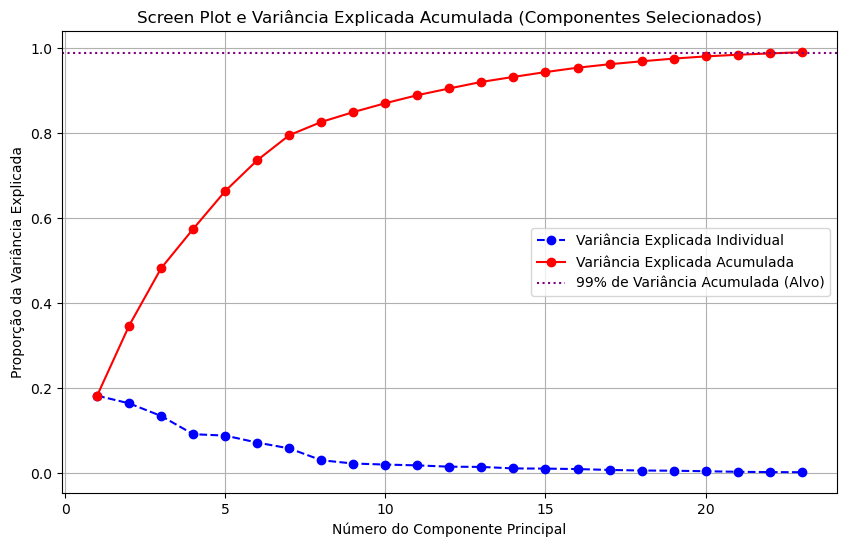

In [48]:
# 5. Plotando o Screen Plot e a Variância Acumulada

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='blue', label='Variância Explicada Individual')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='red', label='Variância Explicada Acumulada')
plt.title('Screen Plot e Variância Explicada Acumulada (Componentes Selecionados)')
plt.xlabel('Número do Componente Principal')
plt.ylabel('Proporção da Variância Explicada')
plt.axhline(y=0.99, color='purple', linestyle=':', label='99% de Variância Acumulada (Alvo)')
plt.grid(True)
plt.legend()
plt.show()


--- Contribuição das Variáveis Originais para cada Componente Principal (Loadings) ---
      IPCA Bens Ind Var Mensal %_lag_1  IPCA Bens Ind Var Mensal %_lag_2  \
PC1                          -0.005130                         -0.048894   
PC2                           0.052934                          0.051384   
PC3                           0.052738                         -0.039492   
PC4                           0.039107                         -0.075331   
PC5                          -0.124535                         -0.110051   
PC6                          -0.086984                         -0.098385   
PC7                           0.432918                          0.466762   
PC8                          -0.260052                         -0.108667   
PC9                          -0.449757                         -0.249724   
PC10                         -0.061483                          0.180444   
PC11                         -0.343573                          0.494403   


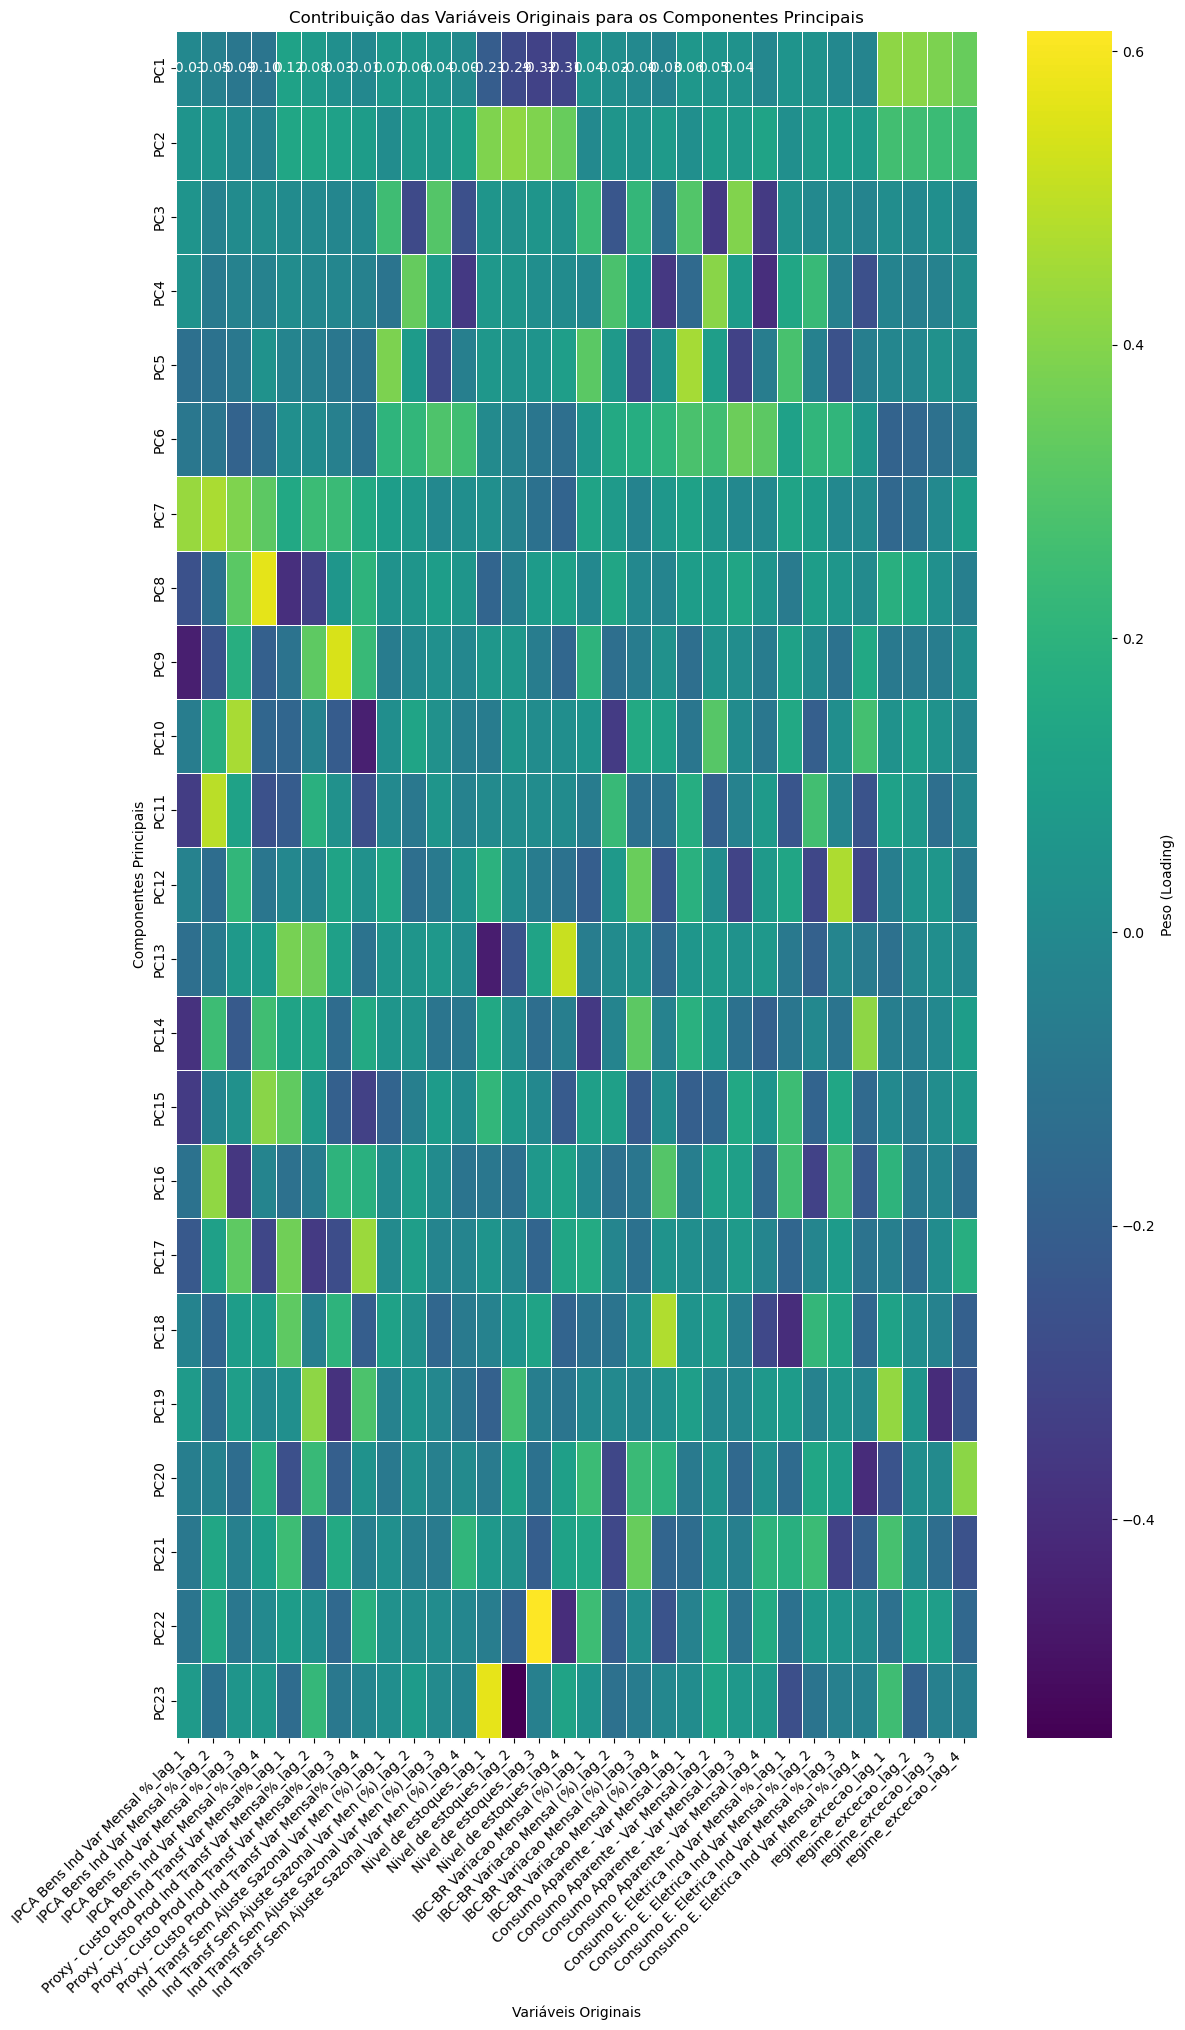


--- Interpretação dos Loadings ---
Os valores na tabela/heatmap representam o peso de cada variável original na formação de cada Componente Principal.
  - Valores absolutos mais altos (seja positivo ou negativo) indicam uma maior contribuição daquela variável para o componente.
  - O sinal (+ ou -) indica a direção da relação:
    - Sinal positivo: A variável aumenta na mesma direção que o componente.
    - Sinal negativo: A variável aumenta na direção oposta ao componente.


In [49]:
# 6. Análise das contribuições das variáveis originais

# Obter os nomes das colunas originais (features)
feature_names = X_trein_scaled.columns.tolist()

# Obter a matriz de componentes (loadings)
# Cada linha é um componente principal, cada coluna é uma feature original
components_matrix = pca.components_

# Criar um DataFrame para facilitar a visualização e interpretação
# O índice são os componentes (PC1, PC2, etc.)
# As colunas são as features originais
components_df = pd.DataFrame(data=components_matrix,
                             columns=feature_names,
                             index=[f'PC{i+1}' for i in range(components_matrix.shape[0])])

print("\n--- Contribuição das Variáveis Originais para cada Componente Principal (Loadings) ---")
print(components_df)

# Opcional: Visualização em um Heatmap (útil para muitas variáveis)
plt.figure(figsize=(12, (components_df.shape[0] * 0.8) + 2)) # Ajusta o tamanho baseado no número de componentes
sns.heatmap(components_df, cmap='viridis', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Peso (Loading)'})
plt.title('Contribuição das Variáveis Originais para os Componentes Principais')
plt.xlabel('Variáveis Originais')
plt.ylabel('Componentes Principais')
plt.xticks(rotation=45, ha='right') # Gira os rótulos das colunas para melhor visualização
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

print("\n--- Interpretação dos Loadings ---")
print("Os valores na tabela/heatmap representam o peso de cada variável original na formação de cada Componente Principal.")
print("  - Valores absolutos mais altos (seja positivo ou negativo) indicam uma maior contribuição daquela variável para o componente.")
print("  - O sinal (+ ou -) indica a direção da relação:")
print("    - Sinal positivo: A variável aumenta na mesma direção que o componente.")
print("    - Sinal negativo: A variável aumenta na direção oposta ao componente.")


In [ ]:
# 6. Inicializando o PCA com o número de componentes que explicam 99% da variância

# Transformando os dados de treinamento para os novos componentes principais
#X_trein_pca_99 = pca.transform(X_trein_scaled)

# Transformando os dados de teste para os novos componentes principais
#X_teste_pca_99 = pca.transform(X_teste_scaled)

### Nomeando as colunas dos novos dataframes X_trein_pca_99 e X_teste_pca_99

In [ ]:
# Número de componentes principais que foram selecionados pelo PCA
#num_components = pca.n_components_ # Isso será 11, conforme o último output

# Criar nomes para as novas colunas
#pca_column_names = [f'PC{i+1}' for i in range(num_components)]

# Converter X_trein_pca_99 para DataFrame e atribuir nomes às colunas e o índice original
#X_trein_pca_99_df = pd.DataFrame(X_trein_pca_99,
                                 #columns=pca_column_names,
                                 #index=X_trein_scaled.index) # Usar o índice do dataframe escalonado original

# Converter X_teste_pca_99 para DataFrame e atribuir nomes às colunas e o índice original
#X_teste_pca_99_df = pd.DataFrame(X_teste_pca_99,
                                 #columns=pca_column_names,
                                 #index=X_teste_scaled.index) # Usar o índice do dataframe escalonado original

#print("Primeiras 5 linhas de X_trein_pca_99_df com os novos nomes das colunas:")
#print(X_trein_pca_99_df.head())

#print("\nPrimeiras 5 linhas de X_teste_pca_99_df com os novos nomes das colunas:")
#print(X_teste_pca_99_df.head())

#print(f"\nShape de X_trein_pca_99_df: {X_trein_pca_99_df.shape}")
#print(f"Shape de X_teste_pca_99_df: {X_teste_pca_99_df.shape}")

### Função para Criação de Sliding Windows

In [50]:
#Criação de função para criar sliding windows:

def create_sliding_windows(X, y, window_size, horizon):
    """
    Cria sequências de entrada (X_seq) e saídas (y_seq) usando sliding window para treinamento de RNNs.

    Args:
        X (pd.DataFrame ou np.array): Features de entrada (já transformadas, ex: PCA e escalonadas).
                                     Esperado formato 2D (amostras, features).
        y (pd.Series ou np.array): Variável alvo (já escalonada).
                                   Esperado formato 1D (amostras,) ou 2D (amostras, 1).
        window_size (int): Número de passos (observações passadas) para cada sequência de entrada.
        horizon (int, opcional): Número de passos futuros a serem previstos. Default é 1.

    Returns:
        tuple: (X_sequences, y_sequences)
            X_sequences (np.array): Array 3D no formato (amostras, window_size, features).
            y_sequences (np.array): Array 2D no formato (amostras, horizon).
    """
    X_sequences, y_sequences = [], []
    num_samples = len(X)

    # Converte X e y para arrays NumPy para garantir compatibilidade
    if isinstance(X, pd.DataFrame):
        X_vals = X.values
    else:
        X_vals = X

    if isinstance(y, pd.Series):
        y_vals = y.values
    elif isinstance(y, np.ndarray) and y.ndim == 2:
        y_vals = y # Já está 2D
    else:
        y_vals = y.reshape(-1, 1) # Garante que y é 2D

    for i in range(num_samples - window_size - horizon + 1):
        # A sequência de entrada (X) vai de 'i' até 'i + window_size'
        X_seq = X_vals[i : (i + window_size)]
        X_sequences.append(X_seq)

        # A saída (y) é o valor do horizonte, começando de 'i + window_size'
        y_seq = y_vals[(i + window_size) : (i + window_size + horizon)]
        y_sequences.append(y_seq)

    return np.array(X_sequences), np.array(y_sequences)


In [51]:
# Definindo os parâmetros para a criação das janelas deslizantes

window_size = 3
horizon = 1

In [52]:
print(f"\n--- Criando sequências com Window Size = {window_size} e Horizon = {horizon} ---")

# Criando sequências para o conjunto de TREINAMENTO
X_trein_seq, y_trein_seq = create_sliding_windows(X_trein_scaled, y_trein_scaled, window_size, horizon)
print(f"Formato de X_trein_seq: {X_trein_seq.shape} (amostras, window_size, features)")
print(f"Formato de y_trein_seq: {y_trein_seq.shape} (amostras, horizon)")


--- Criando sequências com Window Size = 3 e Horizon = 1 ---
Formato de X_trein_seq: (185, 3, 32) (amostras, window_size, features)
Formato de y_trein_seq: (185, 1) (amostras, horizon)


In [53]:
# Criando sequências para o conjunto de TESTE
X_teste_seq, y_teste_seq = create_sliding_windows(X_teste_scaled, y_teste_scaled, window_size, horizon)
print(f"Formato de X_teste_seq: {X_teste_seq.shape} (amostras, window_size, features)")
print(f"Formato de y_teste_seq: {y_teste_seq.shape} (amostras, horizon)")

Formato de X_teste_seq: (45, 3, 32) (amostras, window_size, features)
Formato de y_teste_seq: (45, 1) (amostras, horizon)


### Desenvolvimento de Modelos de Redes Neurais

Serão testados diversas arquiteturas de Redes Neurais Artificiais:

SimpleRNN: São as mais básicas. São boas para começar como um benchmark de linha de base. No entanto, elas frequentemente sofrem com o problema do "gradiente evanescente" ou "explodindo" (vanishing/exploding gradient problem), o que as torna menos eficazes para capturar dependências de longo prazo em sequências. Seus pesos podem ter dificuldade em aprender com o tempo em sequências muito longas.


LSTM (Long Short-Term Memory): São uma melhoria significativa sobre as SimpleRNNs. Elas possuem "portões" internos (input, forget, output gates) que as ajudam a controlar o fluxo de informações, permitindo que aprendam e retenham informações por longos períodos de tempo. São muito utilizadas e frequentemente eficazes para problemas de séries temporais complexas.


GRU (Gated Recurrent Unit): São uma versão simplificada das LSTMs. Elas também têm portões, mas com uma arquitetura menos complexa (dois portões em vez de três). Muitas vezes, as GRUs podem ter um desempenho comparável às LSTMs, mas com menos parâmetros para treinar, tornando-as mais rápidas e eficientes computacionalmente.


Modelos Híbridos: A combinação de diferentes tipos de camadas (por exemplo, uma camada Conv1D antes de uma LSTM, ou múltiplas camadas LSTM ou GRU empilhadas, ou mesmo Dense layers adicionais) pode capturar padrões mais complexos. Um Conv1D pode ser útil para extrair características espaciais dentro da sua janela de tempo, antes de alimentar essas características para uma camada recorrente.

In [54]:
# Criação de sementes para que se obtenham os mesmos resultados ao rodar o código: 

SEED = 75

# Definição da semente para a biblioteca random do Python
random.seed(SEED)
# Definição da semente para o Numpy
np.random.seed(SEED)
# Definição da semente para o TensorFlow
tf.random.set_seed(SEED)

In [ ]:
y_trein_seq.shape[1]

In [ ]:
X_trein_seq.shape[1]

In [ ]:
X_trein_seq.shape[2]

In [55]:
# Desenvolvimento de múltiplas arquiteturas de Redes Neurais para teste com validação cruzada de séries temporais:


# --- 1. DEFINIÇÃO DAS ARQUITETURAS PARA TESTAR ---
configs = [
    {'label': 'SimpleRNN_64',       'layer_type': 'SimpleRNN', 'units': [64], 'dropout': 0.1},
    {'label': 'LSTM_64',            'layer_type': 'LSTM',      'units': [64], 'dropout': 0.1},
    {'label': 'LSTM_128',            'layer_type': 'LSTM',      'units': [128], 'dropout': 0.2}, 
    {'label': 'GRU_64',             'layer_type': 'GRU',       'units': [64], 'dropout': 0.1},
    {'label': 'GRU_128',             'layer_type': 'GRU',       'units': [128], 'dropout': 0.2},
    {'label': 'GRU_256',             'layer_type': 'GRU',       'units': [256], 'dropout': 0.1},
    {'label': 'Stacked_LSTM_64x32','layer_type': 'LSTM',      'units': [64, 32], 'dropout': 0.2},
    {'label': 'Stacked_GRU_64x32', 'layer_type': 'GRU',       'units': [64, 32], 'dropout': 0.2}
]

# Dicionário para guardar os resultados
resultados_rmse = {}

# --- 2. LOOP PARA AS CONFIGURAÇÕES COM VALIDAÇÃO CRUZADA DE SÉRIES TEMPORAIS ---
print("\n" + "="*70)
print("------ INICIANDO TESTE DE MÚLTIPLAS ARQUITETURAS RNN COM TSCV ------")
print("="*70 + "\n")

# Parâmetros fixos para o loop
n_splits = 6 # Número de splits para TimeSeriesSplit
epochs = 100
batch_size = 32
patience = 10 # Para EarlyStopping

# Determinar o input_shape e output_horizon uma vez
input_shape = (X_trein_seq.shape[1], X_trein_seq.shape[2]) # (window_size, num_features)
output_horizon = y_trein_seq.shape[1] # Será 1, conforme definido pelo horizon

for config in configs:
    print(f"--- INICIANDO TESTE PARA: {config['label']} ---")
    
    fold_scores = []
    # TimeSeriesSplit para validação cruzada
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Note: tscv.split() é aplicado em X_trein_seq, mas o split real é feito nos índices.
    # Usaremos X_trein_seq e y_trein_seq diretamente dentro do loop.
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_trein_seq)): # tscv.split(X_trein_seq)
        print(f"  > Fold {fold + 1}/{n_splits} para {config['label']}")
        
        # Divisão dos dados em treino e validação para o fold atual
        X_train_fold, X_val_fold = X_trein_seq[train_idx], X_trein_seq[val_idx]
        y_train_fold, y_val_fold = y_trein_seq[train_idx], y_trein_seq[val_idx]

        # --- Construção dinâmica do modelo ---
        model = Sequential()
        units_list = config['units']
        layer_type = config['layer_type']
        
        for i, units in enumerate(units_list):
            is_last_recurrent_layer = (i == len(units_list) - 1)
            
            # Adiciona a camada recorrente (com input_shape apenas na primeira)
            if layer_type == 'SimpleRNN':
                model.add(SimpleRNN(units, activation='tanh', 
                                    return_sequences=not is_last_recurrent_layer,
                                    input_shape=input_shape if i == 0 else None))
            elif layer_type == 'LSTM':
                model.add(LSTM(units, activation='tanh', 
                               return_sequences=not is_last_recurrent_layer,
                               input_shape=input_shape if i == 0 else None))
            else: # GRU
                model.add(GRU(units, activation='tanh', 
                              return_sequences=not is_last_recurrent_layer,
                              input_shape=input_shape if i == 0 else None))
        
        # Adiciona Dropout se especificado (após as camadas recorrentes)
        if config['dropout'] > 0:
            model.add(Dropout(config['dropout']))
        
        # Camada de saída (o número de unidades é igual ao horizonte de previsão)
        model.add(Dense(output_horizon)) # Corrigido para output_horizon (3)
        
        # Compilar o modelo
        # Otimizador Adam e Mean Squared Error (MSE) como função de perda para regressão
        model.compile(optimizer='adam', loss='mse')
        # --- Fim da construção do modelo ---
        
        # Early Stopping para monitorar a val_loss
        es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)
        
        # Treinamento do modelo
        history = model.fit(X_train_fold, y_train_fold, 
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])

        # Previsões no conjunto de validação
        y_pred_scaled_fold = model.predict(X_val_fold, verbose=0)
        
        # --- Reversão da escala para o cálculo do RMSE e outras métricas ---
        # y_pred_scaled_fold e y_val_fold já são (amostras, horizon)
        # scaler_y foi fitado para (amostras, 1), então precisamos reverter coluna por coluna
        
        # Forma mais robusta de desescalar multi-output com scaler de uma feature:
        # Desescalar cada valor da previsão (flatten), depois reshape de volta para (amostras, horizon)
        y_pred_descaled_flat = scaler_y.inverse_transform(y_pred_scaled_fold.flatten().reshape(-1, 1)).flatten()
        y_val_descaled_flat = scaler_y.inverse_transform(y_val_fold.flatten().reshape(-1, 1)).flatten()

        # Calcular RMSE para o fold atual
        rmse_fold = np.sqrt(mean_squared_error(y_val_descaled_flat, y_pred_descaled_flat))
        fold_scores.append(rmse_fold)
        print(f"    RMSE no Fold {fold + 1}: {rmse_fold:.5f}")

    # Calcular o RMSE médio para a configuração atual
    rmse_medio = np.mean(fold_scores)
    resultados_rmse[config['label']] = rmse_medio
    print(f"--> RMSE Médio para '{config['label']}': {rmse_medio:.5f}\n")

# --- 3. APRESENTAÇÃO DO RESULTADO FINAL ---
print("="*50)
print("------ RESULTADO FINAL DOS TESTES DE ARQUITETURA ------")
# Ordenar os resultados pelo RMSE médio (do menor para o maior)
for config_label, rmse_result in sorted(resultados_rmse.items(), key=lambda item: item[1]):
    print(f"{config_label}: RMSE Médio = {rmse_result:.5f}")

# Encontrar a melhor arquitetura
melhor_config_label = min(resultados_rmse, key=resultados_rmse.get)
print(f"\nMelhor Arquitetura encontrada: {melhor_config_label} (RMSE Médio: {resultados_rmse[melhor_config_label]:.5f})")

# Opcional: Para obter a melhor configuração completa
melhor_config = next(item for item in configs if item["label"] == melhor_config_label)
print("\nDetalhes da Melhor Configuração:")
print(melhor_config)


------ INICIANDO TESTE DE MÚLTIPLAS ARQUITETURAS RNN COM TSCV ------

--- INICIANDO TESTE PARA: SimpleRNN_64 ---
  > Fold 1/6 para SimpleRNN_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 1: 0.43767
  > Fold 2/6 para SimpleRNN_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 2: 0.25266
  > Fold 3/6 para SimpleRNN_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 3: 0.33780
  > Fold 4/6 para SimpleRNN_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 4: 0.23964
  > Fold 5/6 para SimpleRNN_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 5: 0.24459
  > Fold 6/6 para SimpleRNN_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 6: 0.45180
--> RMSE Médio para 'SimpleRNN_64': 0.32736

--- INICIANDO TESTE PARA: LSTM_64 ---
  > Fold 1/6 para LSTM_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 1: 0.23611
  > Fold 2/6 para LSTM_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 2: 0.22893
  > Fold 3/6 para LSTM_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 3: 0.33579
  > Fold 4/6 para LSTM_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 4: 0.28547
  > Fold 5/6 para LSTM_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 5: 0.17613
  > Fold 6/6 para LSTM_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 6: 0.40742
--> RMSE Médio para 'LSTM_64': 0.27831

--- INICIANDO TESTE PARA: LSTM_128 ---
  > Fold 1/6 para LSTM_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 1: 0.26587
  > Fold 2/6 para LSTM_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 2: 0.22156
  > Fold 3/6 para LSTM_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 3: 0.31695
  > Fold 4/6 para LSTM_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 4: 0.29771
  > Fold 5/6 para LSTM_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 5: 0.17907
  > Fold 6/6 para LSTM_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 6: 0.38700
--> RMSE Médio para 'LSTM_128': 0.27803

--- INICIANDO TESTE PARA: GRU_64 ---
  > Fold 1/6 para GRU_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 1: 0.25282
  > Fold 2/6 para GRU_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 2: 0.21855
  > Fold 3/6 para GRU_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 3: 0.29900
  > Fold 4/6 para GRU_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 4: 0.28589
  > Fold 5/6 para GRU_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 5: 0.20020
  > Fold 6/6 para GRU_64


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 6: 0.37892
--> RMSE Médio para 'GRU_64': 0.27256

--- INICIANDO TESTE PARA: GRU_128 ---
  > Fold 1/6 para GRU_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 1: 0.25364
  > Fold 2/6 para GRU_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 2: 0.22630
  > Fold 3/6 para GRU_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 3: 0.30686
  > Fold 4/6 para GRU_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 4: 0.26270
  > Fold 5/6 para GRU_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 5: 0.18194
  > Fold 6/6 para GRU_128


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 6: 0.40662
--> RMSE Médio para 'GRU_128': 0.27301

--- INICIANDO TESTE PARA: GRU_256 ---
  > Fold 1/6 para GRU_256


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 1: 0.25248
  > Fold 2/6 para GRU_256


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 2: 0.22019
  > Fold 3/6 para GRU_256


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 3: 0.30611
  > Fold 4/6 para GRU_256


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 4: 0.21116
  > Fold 5/6 para GRU_256


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 5: 0.16465
  > Fold 6/6 para GRU_256


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 6: 0.41093
--> RMSE Médio para 'GRU_256': 0.26092

--- INICIANDO TESTE PARA: Stacked_LSTM_64x32 ---
  > Fold 1/6 para Stacked_LSTM_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 1: 0.24054
  > Fold 2/6 para Stacked_LSTM_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 2: 0.23571
  > Fold 3/6 para Stacked_LSTM_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 3: 0.31688
  > Fold 4/6 para Stacked_LSTM_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 4: 0.27095
  > Fold 5/6 para Stacked_LSTM_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 5: 0.16945
  > Fold 6/6 para Stacked_LSTM_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 6: 0.40952
--> RMSE Médio para 'Stacked_LSTM_64x32': 0.27384

--- INICIANDO TESTE PARA: Stacked_GRU_64x32 ---
  > Fold 1/6 para Stacked_GRU_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 1: 0.27159
  > Fold 2/6 para Stacked_GRU_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 2: 0.22479
  > Fold 3/6 para Stacked_GRU_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 3: 0.31171
  > Fold 4/6 para Stacked_GRU_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 4: 0.27794
  > Fold 5/6 para Stacked_GRU_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 5: 0.17632
  > Fold 6/6 para Stacked_GRU_64x32


C:\Users\prisc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    RMSE no Fold 6: 0.53205
--> RMSE Médio para 'Stacked_GRU_64x32': 0.29907

------ RESULTADO FINAL DOS TESTES DE ARQUITETURA ------
GRU_256: RMSE Médio = 0.26092
GRU_64: RMSE Médio = 0.27256
GRU_128: RMSE Médio = 0.27301
Stacked_LSTM_64x32: RMSE Médio = 0.27384
LSTM_128: RMSE Médio = 0.27803
LSTM_64: RMSE Médio = 0.27831
Stacked_GRU_64x32: RMSE Médio = 0.29907
SimpleRNN_64: RMSE Médio = 0.32736

Melhor Arquitetura encontrada: GRU_256 (RMSE Médio: 0.26092)

Detalhes da Melhor Configuração:
{'label': 'GRU_256', 'layer_type': 'GRU', 'units': [256], 'dropout': 0.1}


O melhor modelo, GRU_258, alcançou um RMSE médio de validação de 0.2609. Este valor não é melhor do que melhor resultado que já havia sido obtido antes (~0.24677) sem aplicação de defasagem em todas as variáveis explicativas. Em relação aos métodos de machine learning, o melhor resultado foi com o XGBoost, cujo RMSE do modelo de treinamento foi de 0.2587.



### Testando outras arquiteturas

In [56]:
# --- 1. DEFINIÇÃO DAS ARQUITETURAS PARA TESTAR (VERSÃO OTIMIZADA) ---
configs = [
    # Manter as bases para referência e comparação
    {'label': 'GRU_256_base',                'layer_type': 'GRU',  'units': [256], 'dropout': 0.2},
    {'label': 'LSTM_128_base',               'layer_type': 'LSTM', 'units': [128], 'dropout': 0.2},
    {'label': 'Stacked_GRU_64x32_base',      'layer_type': 'GRU',  'units': [64, 32], 'dropout': 0.2},
    {'label': 'Stacked_LSTM_64x32_base',     'layer_type': 'LSTM', 'units': [64, 32], 'dropout': 0.2},

    # --- VARIAÇÕES FOCO GRU (EM TORNO DO MELHOR MODELO) ---
    # 1. Variar Dropout para GRU_256
    {'label': 'GRU_256_d0.1', 'layer_type': 'GRU', 'units': [256], 'dropout': 0.1},
    {'label': 'GRU_256_d0.3', 'layer_type': 'GRU', 'units': [256], 'dropout': 0.3},
    
    # 2. Variar Capacidade para Stacked GRU
    {'label': 'Stacked_GRU_128x64', 'layer_type': 'GRU', 'units': [128, 64], 'dropout': 0.2},
    {'label': 'Stacked_GRU_64x64',  'layer_type': 'GRU', 'units': [64, 64], 'dropout': 0.2},

    # --- VARIAÇÕES FOCO LSTM (EM TORNO DOS MELHORES CANDIDATOS) ---
    # 1. Variar Dropout para LSTM_128 (ADICIONADO)
    {'label': 'LSTM_128_d0.1', 'layer_type': 'LSTM', 'units': [128], 'dropout': 0.1},
    {'label': 'LSTM_128_d0.3', 'layer_type': 'LSTM', 'units': [128], 'dropout': 0.3},

    # 2. Variar Dropout para Stacked LSTM
    {'label': 'Stacked_LSTM_64x32_d0.1', 'layer_type': 'LSTM', 'units': [64, 32], 'dropout': 0.1},
    {'label': 'Stacked_LSTM_64x32_d0.3', 'layer_type': 'LSTM', 'units': [64, 32], 'dropout': 0.3},
    
    # 3. Aumentar Capacidade para LSTM Stacked
    {'label': 'Stacked_LSTM_128x64', 'layer_type': 'LSTM', 'units': [128, 64], 'dropout': 0.2},
    {'label': 'Stacked_LSTM_64x64',  'layer_type': 'LSTM', 'units': [64, 64], 'dropout': 0.2},
]

# Dicionário para guardar os resultados
resultados_rmse = {}

# --- 2. LOOP PARA AS CONFIGURAÇÕES COM VALIDAÇÃO CRUZADA DE SÉRIES TEMPORAIS ---
print("\n" + "="*70)
print("------ INICIANDO TESTE DE MÚLTIPLAS ARQUITETURAS RNN COM TSCV (RODADA 2 FINAL) ------")
print("="*70 + "\n")

# Parâmetros fixos para o loop
n_splits = 6
epochs = 100
batch_size = 32
patience = 10

# Determinar o input_shape e output_horizon uma vez
input_shape = (X_trein_seq.shape[1], X_trein_seq.shape[2])
# A forma de y_trein_seq é (amostras, horizon, 1), então pegamos a dimensão do meio
output_horizon = y_trein_seq.shape[1] 

for config in configs:
    print(f"--- INICIANDO TESTE PARA: {config['label']} ---")
    
    fold_scores = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_trein_seq)):
        print(f"  > Fold {fold + 1}/{n_splits} para {config['label']}")
        
        X_train_fold, X_val_fold = X_trein_seq[train_idx], X_trein_seq[val_idx]
        y_train_fold, y_val_fold = y_trein_seq[train_idx], y_trein_seq[val_idx]

        # --- Construção dinâmica do modelo ---
        model = Sequential()
        model.add(tf.keras.layers.Input(shape=input_shape))

        units_list = config['units']
        layer_type = config['layer_type']
        
        for i, units in enumerate(units_list):
            is_last_recurrent_layer = (i == len(units_list) - 1)
            
            if layer_type == 'LSTM':
                model.add(LSTM(units, activation='tanh', return_sequences=not is_last_recurrent_layer))
            else: # GRU
                model.add(GRU(units, activation='tanh', return_sequences=not is_last_recurrent_layer))
        
        if config['dropout'] > 0:
            model.add(Dropout(config['dropout']))
        
        model.add(Dense(output_horizon))
        
        model.compile(optimizer='adam', loss='mse')
        # --- Fim da construção do modelo ---
        
        es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)
        
        history = model.fit(X_train_fold, y_train_fold, 
                              validation_data=(X_val_fold, y_val_fold),
                              epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])

        y_pred_scaled_fold = model.predict(X_val_fold, verbose=0)
        
        y_pred_descaled_flat = scaler_y.inverse_transform(y_pred_scaled_fold.flatten().reshape(-1, 1)).flatten()
        y_val_descaled_flat = scaler_y.inverse_transform(y_val_fold.flatten().reshape(-1, 1)).flatten()

        rmse_fold = np.sqrt(mean_squared_error(y_val_descaled_flat, y_pred_descaled_flat))
        fold_scores.append(rmse_fold)
        print(f"    RMSE no Fold {fold + 1}: {rmse_fold:.5f}")

    rmse_medio = np.mean(fold_scores)
    resultados_rmse[config['label']] = rmse_medio
    print(f"--> RMSE Médio para '{config['label']}': {rmse_medio:.5f}\n")

# --- 3. APRESENTAÇÃO DO RESULTADO FINAL ---
print("="*50)
print("------ RESULTADO FINAL DOS TESTES DE ARQUITETURA (RODADA 2 FINAL) ------")
for config_label, rmse_result in sorted(resultados_rmse.items(), key=lambda item: item[1]):
    print(f"{config_label}: RMSE Médio = {rmse_result:.5f}")

melhor_config_label = min(resultados_rmse, key=resultados_rmse.get)
print(f"\nMelhor Arquitetura encontrada: {melhor_config_label} (RMSE Médio: {resultados_rmse[melhor_config_label]:.5f})")

melhor_config = next(item for item in configs if item["label"] == melhor_config_label)
print("\nDetalhes da Melhor Configuração:")
print(melhor_config)


------ INICIANDO TESTE DE MÚLTIPLAS ARQUITETURAS RNN COM TSCV (RODADA 2 FINAL) ------

--- INICIANDO TESTE PARA: GRU_256_base ---
  > Fold 1/6 para GRU_256_base
    RMSE no Fold 1: 0.23480
  > Fold 2/6 para GRU_256_base
    RMSE no Fold 2: 0.22350
  > Fold 3/6 para GRU_256_base
    RMSE no Fold 3: 0.31049
  > Fold 4/6 para GRU_256_base
    RMSE no Fold 4: 0.22452
  > Fold 5/6 para GRU_256_base
    RMSE no Fold 5: 0.17449
  > Fold 6/6 para GRU_256_base
    RMSE no Fold 6: 0.33899
--> RMSE Médio para 'GRU_256_base': 0.25113

--- INICIANDO TESTE PARA: LSTM_128_base ---
  > Fold 1/6 para LSTM_128_base
    RMSE no Fold 1: 0.24067
  > Fold 2/6 para LSTM_128_base
    RMSE no Fold 2: 0.24387
  > Fold 3/6 para LSTM_128_base
    RMSE no Fold 3: 0.30596
  > Fold 4/6 para LSTM_128_base
    RMSE no Fold 4: 0.28909
  > Fold 5/6 para LSTM_128_base
    RMSE no Fold 5: 0.18781
  > Fold 6/6 para LSTM_128_base
    RMSE no Fold 6: 0.37279
--> RMSE Médio para 'LSTM_128_base': 0.27336

--- INICIANDO TESTE 

## Testes de performance com novos parâmetros


### Desenvolvimento de Modelos em Torno das 3 Melhores Configurações:

#### GRU_256_base (dropout = 0.2)

#### Stacked_GRU_128x64 (dropout = 0.2) e

#### GRU_256_d0.3 (dropout = 0.3)

#### Variando Batch Size = 16 e 64 e Window Size = 3

In [58]:
# --- 1. DEFINIÇÃO DAS ARQUITETURAS (REFINAMENTO FINAL COM BATCH SIZE) ---
configs = []

# Lista com os 3 melhores modelos da rodada anterior para testar com novos batch_sizes
base_configs_to_test = [
    {'label_prefix': 'GRU_256_base_d0.2',         'layer_type': 'GRU', 'units': [256],    'dropout': 0.2},
    {'label_prefix': 'GRU_256_base_d0.3',         'layer_type': 'GRU', 'units': [256],    'dropout': 0.3},
    {'label_prefix': 'GRU_256_base_d0.1',         'layer_type': 'GRU', 'units': [256],    'dropout': 0.1},
    {'label_prefix': 'Stacked_GRU_128x64',   'layer_type': 'GRU', 'units': [128, 64],'dropout': 0.2},
    {'label_prefix': 'GRU_256_d0.3',         'layer_type': 'GRU', 'units': [256],    'dropout': 0.3}
]

# Lista de batch_sizes para testar
batch_sizes_to_test = [16, 64]

# Loop para criar as variações de configuração
for base_config in base_configs_to_test:
    for bs in batch_sizes_to_test:
        configs.append({
            'label': f"{base_config['label_prefix']}_b{bs}",
            'layer_type': base_config['layer_type'],
            'units': base_config['units'],
            'dropout': base_config['dropout'],
            'batch_size': bs  # Adiciona a chave 'batch_size' à configuração
        })

# --- 2. LOOP PARA AS CONFIGURAÇÕES COM VALIDAÇÃO CRUZADA ---
print("\n" + "="*70)
print("------ INICIANDO TESTE DE REFINAMENTO FINAL COM BATCH SIZE ------")
print("="*70 + "\n")

# Dicionário para guardar os resultados
resultados_rmse = {}

# Parâmetros do loop
n_splits = 6
epochs = 100
patience = 10
input_shape = (X_trein_seq.shape[1], X_trein_seq.shape[2])
output_horizon = y_trein_seq.shape[1]

for config in configs:
    print(f"--- INICIANDO TESTE PARA: {config['label']} ---")
    
    fold_scores = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_trein_seq)):
        print(f"  > Fold {fold + 1}/{n_splits} para {config['label']}")
        
        X_train_fold, X_val_fold = X_trein_seq[train_idx], X_trein_seq[val_idx]
        y_train_fold, y_val_fold = y_trein_seq[train_idx], y_trein_seq[val_idx]

        # --- Construção do modelo ---
        model = Sequential()
        model.add(tf.keras.layers.Input(shape=input_shape))
        
        units_list = config['units']
        layer_type = config['layer_type']
        
        for i, units in enumerate(units_list):
            is_last_recurrent_layer = (i == len(units_list) - 1)
            
            if layer_type == 'GRU':
                model.add(GRU(units, activation='tanh', return_sequences=not is_last_recurrent_layer))
            elif layer_type == 'LSTM': # Mantido para flexibilidade, embora não usado nesta rodada
                model.add(LSTM(units, activation='tanh', return_sequences=not is_last_recurrent_layer))
        
        if config['dropout'] > 0:
            model.add(Dropout(config['dropout']))
        
        model.add(Dense(output_horizon))
        
        model.compile(optimizer='adam', loss='mse')
        
        # --- Treinamento ---
        es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)
        
        model.fit(X_train_fold, y_train_fold, 
                  validation_data=(X_val_fold, y_val_fold),
                  epochs=epochs, 
                  batch_size=config['batch_size'], # Usa o batch_size da configuração
                  verbose=0, 
                  callbacks=[es])

        # --- Avaliação ---
        y_pred_scaled_fold = model.predict(X_val_fold, verbose=0)
        
        # Lógica de inverse_transform robusta para lidar com as dimensões
        y_pred_descaled = scaler_y.inverse_transform(y_pred_scaled_fold.reshape(-1, 1)).flatten()
        y_val_descaled = scaler_y.inverse_transform(y_val_fold.reshape(-1, 1)).flatten()

        rmse_fold = np.sqrt(mean_squared_error(y_val_descaled, y_pred_descaled))
        fold_scores.append(rmse_fold)
        print(f"    RMSE no Fold {fold + 1}: {rmse_fold:.5f}")

    rmse_medio = np.mean(fold_scores)
    resultados_rmse[config['label']] = rmse_medio
    print(f"--> RMSE Médio para '{config['label']}': {rmse_medio:.5f}\n")

# --- 3. APRESENTAÇÃO DO RESULTADO FINAL ---
print("="*50)
print("------ RESULTADO FINAL DO REFINAMENTO DE BATCH SIZE ------")
for config_label, rmse_result in sorted(resultados_rmse.items(), key=lambda item: item[1]):
    print(f"{config_label}: RMSE Médio = {rmse_result:.5f}")

melhor_config_label = min(resultados_rmse, key=resultados_rmse.get)
print(f"\nMelhor Arquitetura encontrada: {melhor_config_label} (RMSE Médio: {resultados_rmse[melhor_config_label]:.5f})")

melhor_config = next(item for item in configs if item["label"] == melhor_config_label)
print("\nDetalhes da Melhor Configuração:")
print(melhor_config)


------ INICIANDO TESTE DE REFINAMENTO FINAL COM BATCH SIZE ------

--- INICIANDO TESTE PARA: GRU_256_base_d0.2_b16 ---
  > Fold 1/6 para GRU_256_base_d0.2_b16
    RMSE no Fold 1: 0.21884
  > Fold 2/6 para GRU_256_base_d0.2_b16
    RMSE no Fold 2: 0.21466
  > Fold 3/6 para GRU_256_base_d0.2_b16
    RMSE no Fold 3: 0.30256
  > Fold 4/6 para GRU_256_base_d0.2_b16
    RMSE no Fold 4: 0.21263
  > Fold 5/6 para GRU_256_base_d0.2_b16
    RMSE no Fold 5: 0.19481
  > Fold 6/6 para GRU_256_base_d0.2_b16
    RMSE no Fold 6: 0.33004
--> RMSE Médio para 'GRU_256_base_d0.2_b16': 0.24559

--- INICIANDO TESTE PARA: GRU_256_base_d0.2_b64 ---
  > Fold 1/6 para GRU_256_base_d0.2_b64
    RMSE no Fold 1: 0.25331
  > Fold 2/6 para GRU_256_base_d0.2_b64
    RMSE no Fold 2: 0.24825
  > Fold 3/6 para GRU_256_base_d0.2_b64
    RMSE no Fold 3: 0.32675
  > Fold 4/6 para GRU_256_base_d0.2_b64
    RMSE no Fold 4: 0.24896
  > Fold 5/6 para GRU_256_base_d0.2_b64
    RMSE no Fold 5: 0.16937
  > Fold 6/6 para GRU_256_

## Conclusão das Diversas Configurações Testadas:

### Rodada 1: Busca Ampla de Arquiteturas

Ação: Teste de uma vasta gama de modelos: SimpleRNN, LSTM e GRU, com diferentes capacidades (número de neurônios) e arquiteturas (camada única vs. empilhada).

Melhor Resultado: O modelo GRU_256 emergiu como o vencedor inicial, com um RMSE médio de ~0.26.

Principal Insight: As arquiteturas GRU se mostraram consistentemente superiores às LSTM e SimpleRNN para este problema, indicando uma melhor adequação da sua estrutura para capturar os padrões presentes nos dados.

### Rodada 2: Otimização de Arquitetura e Dropout

Ação: Foco nos melhores modelos da rodada anterior (principalmente GRU) para refinar hiperparâmetros como dropout e a estrutura das camadas empilhadas.

Melhor Resultado: O modelo GRU_256_base com dropout=0.2 foi confirmado como campeão, mantendo seu RMSE médio (0.25113).

Principal Insight: A taxa de dropout de 0.2 provou ser um ponto ideal de regularização para o modelo mais potente. Além disso, uma camada única "larga" (GRU_256) demonstrou ser ligeiramente mais eficaz que arquiteturas "profundas" (empilhadas).

### Rodada 3: Refinamento Final com batch_size

Ação: Teste dos três melhores modelos da rodada 2, variando o batch_size (tamanho do lote) entre 16 e 64.

Melhor Resultado: O modelo GRU_256_base com dropout=0.2 e batch_size=16 se consagrou como o melhor modelo, atingindo o menor RMSE médio de todo o processo: 0.24559.

Principal Insight: O batch_size menor (16) gerou uma melhora de performance consistente em todos os modelos testados.

Motivo: Um batch_size menor introduz mais "ruído" no processo de otimização do gradiente. Essas atualizações de pesos mais frequentes e ligeiramente mais caóticas podem ajudar o modelo a escapar de mínimos locais ruins e a convergir para um ponto de melhor generalização, resultando em um erro menor.

### Modelo Campeão e Seus Parâmetros

Após um processo iterativo e sistemático de otimização, a configuração final de maior performance foi:

Modelo: GRU_256_base_d0.2_b16

Tipo de Camada: GRU (Gated Recurrent Unit)

Unidades na Camada: 256

Taxa de Dropout: 0.2

Tamanho do Lote (Batch Size): 16

RMSE Médio na Validação Cruzada: 0.24559

### Conclusão Final

A jornada de modelagem demonstrou o valor de uma abordagem estruturada. Partindo de uma decisão estratégica de remover o PCA, passando por uma busca ampla e culminando em um refinamento focado de hiperparâmetros, foi possível não apenas encontrar a melhor arquitetura (GRU), mas também otimizar seus detalhes mais importantes (dropout e batch_size). Cada etapa contribuiu para uma melhora incremental na performance, resultando em um modelo final robusto, confiável e com o maior poder preditivo dentre as configurações avaliadas.

## Construção e Treinamento do Modelo Final

In [60]:
# --- 1. PARÂMETROS DO MODELO CAMPEÃO ---
# Baseado na última e melhor rodada de testes
final_units = [256]
final_dropout = 0.2
final_batch_size = 16
final_epochs = 150 
final_patience = 15

# --- 2. CONSTRUÇÃO DO MODELO FINAL  ---
print("--- Construindo o modelo campeão: GRU_256 (d=0.2, b=16) ---")
model_final = Sequential(name="Modelo_Campeao_GRU256")

# A camada de Input usa os dados sem PCA
model_final.add(tf.keras.layers.Input(shape=(X_trein_seq.shape[1], X_trein_seq.shape[2])))

# Adiciona a ÚNICA camada GRU. Note que return_sequences=False
model_final.add(GRU(units=final_units[0], activation='tanh', return_sequences=False)) 

# Adiciona o Dropout
model_final.add(Dropout(final_dropout))

# Adiciona a camada de saída
model_final.add(Dense(y_trein_seq.shape[1]))


--- Construindo o modelo campeão: GRU_256 (d=0.2, b=16) ---


In [61]:
# Compilação do modelo
model_final.compile(optimizer='adam', loss='mse')

# Resumo da arquitetura final
model_final.summary()

Model: "Modelo_Campeao_GRU256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_192 (GRU)                   │ (None, 256)            │       222,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_226 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,977 (871.00 KB)

 Trainable params: 222,977 (871.00 KB)

 Non-trainable params: 0 (0.00 B)

### Treinamento do Modelo

Será adotada a seguinte abordagem para treinamento do modelo: Treinar com 100% dos dados

Como funciona: Após ter usado a validação cruzada para escolher os melhores hiperparâmetros, confia-se nessa escolha e se treina o modelo final usando todo o conjunto de treinamento (X_trein_seq, y_trein_seq), sem separar dados para validação (validation_split).

Vantagem: Esta abordagem maximiza o aprendizado do modelo. Ele é exposto a todos os padrões presentes nos dados de treino antes de enfrentar o "exame final", que é o conjunto de teste. Este é o procedimento padrão da indústria para gerar o melhor modelo de produção possível.

Desvantagem: é necessárui definir um número fixo de épocas, já que não pode usar EarlyStopping baseado em val_loss. No entanto, se pode estimar um bom número de épocas com base no que foi observado durante a validação cruzada (algo em torno de 40-60 épocas foi suficiente para a convergência).

In [62]:
# --- 3. TREINAMENTO FINAL DO MODELO CAMPEÃO ---

# Parâmetros para o treino final
# O número de épocas foi estimado com base nas rodadas de validação cruzada.
# Não é utilizado EarlyStopping aqui pois não há conjunto de validação.
final_epochs = 60 # Um número seguro para garantir a convergência sem overfitting excessivo.

print("\n" + "="*70)
print(f"--- Iniciando o treinamento final com 100% dos dados de treino por {final_epochs} épocas ---")
print("="*70 + "\n")

# Treinando o modelo com TODOS os dados de treino.
history = model_final.fit(
    X_trein_seq,
    y_trein_seq,
    epochs=final_epochs,
    batch_size=final_batch_size,
    verbose=1 # verbose=1 para acompanhar o progresso do treino final
)

print("\n--- Treinamento final concluído! ---")

# O próximo passo seria a avaliação no conjunto de teste.


--- Iniciando o treinamento final com 100% dos dados de treino por 60 épocas ---

Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2381
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0735
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0307
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0329 
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0249 
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275 
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227 
Epoch 9/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0263 
Epoch 10/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0297
Epoch 11/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0272 
Epoch 12/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0260 
Epoch 13/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270 
Epoch 14/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss:


--- Curva de Aprendizado do Modelo Final (somente treino) ---

Gráfico da curva de aprendizado salvo como 'curva_aprendizado_treino_final.png'


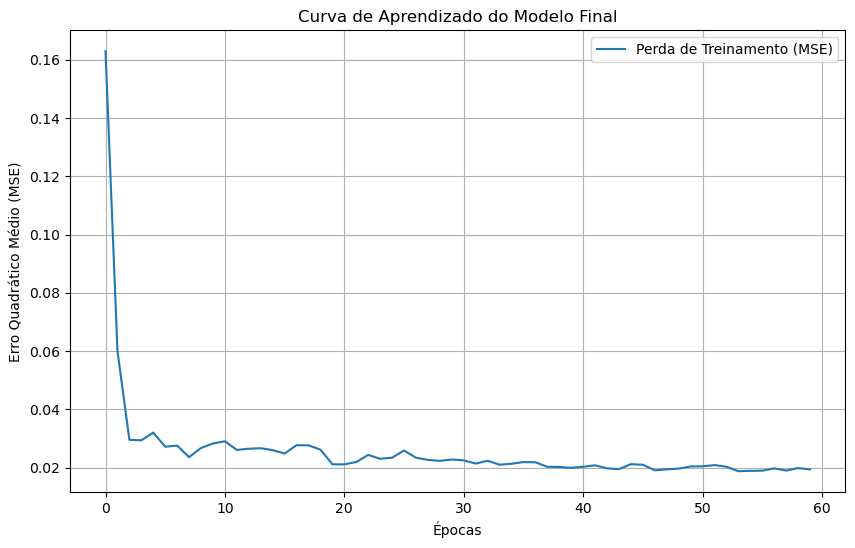

In [63]:
# --- 4. CURVA DE APRENDIZADO DO TREINO FINAL (VERSÃO CORRIGIDA) ---

print("\n--- Curva de Aprendizado do Modelo Final (somente treino) ---")

# Verifica se a chave 'loss' existe no histórico
if 'loss' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Perda de Treinamento (MSE)')
    plt.title('Curva de Aprendizado do Modelo Final')
    plt.xlabel('Épocas')
    plt.ylabel('Erro Quadrático Médio (MSE)')
    plt.legend()
    plt.grid(True)
    plt.savefig('curva_aprendizado_treino_final.png')
    print("\nGráfico da curva de aprendizado salvo como 'curva_aprendizado_treino_final.png'")
else:
    print("Não foi possível encontrar a chave 'loss' no histórico de treinamento para plotar a curva.")

### Interpretação do Gráfico Acima:

O gráfico exibe a evolução da "Perda de Treinamento" (o Erro Quadrático Médio - MSE) do modelo final ao longo das 60 épocas de treinamento. Esta curva é fundamental para diagnosticar a qualidade do processo de aprendizado, mostrando se o modelo está efetivamente aprendendo com os dados de treino e se o treinamento convergiu.

2. Análise do Comportamento da Curva
A curva de aprendizado apresentada demonstra um processo de treinamento eficiente. Os principais pontos a se observar são:

Convergência Rápida Inicial: Nos primeiros 10 a 15 épocas, a curva apresenta uma queda vertiginosa e acentuada. Indica que a arquitetura do modelo e o otimizador (adam) foram escolhas acertadas, permitindo que o modelo rapidamente comece a identificar os padrões mais importantes nos dados e a reduzir seu erro de forma drástica.

Estabilização e Refinamento: Após a queda inicial, a inclinação da curva diminui, e ela continua a descer de forma suave e constante. Esta fase representa o "refinamento" do modelo, onde ele faz ajustes mais finos nos seus pesos para se adequar melhor às nuances dos dados de treinamento.

Ponto de Convergência: Ao se aproximar das 60 épocas, a curva torna-se praticamente horizontal (achatada). Isso é um sinal de que o modelo atingiu a convergência. Ou seja, ele aprendeu o máximo que podia com os dados de treino sob os parâmetros atuais. Continuar o treinamento por muito mais épocas provavelmente não traria ganhos significativos na perda de treino. Isso valida a escolha de treinar por aproximadamente 60 épocas como sendo suficiente.

3. Conclusão
A análise da curva de aprendizado permite concluir que:

O Treinamento foi Bem-Sucedido: O modelo demonstrou uma clara capacidade de aprender, evidenciada pela redução consistente do erro ao longo do tempo.

O Processo foi Estável: A curva é suave e não apresenta picos ou instabilidades, o que sugere que a taxa de aprendizado e o batch_size escolhidos foram adequados, proporcionando uma "descida do gradiente" estável.

A Convergência foi Atingida: O modelo não parou de treinar prematuramente e nem foi treinado por tempo excessivo. Ele atingiu um ponto ótimo de ajuste aos dados de treinamento.

## Salvando Modelo e Parâmetros Localmente

In [64]:
# Definindo pasta onde serão salvos modelo e parâmetros
nome_da_pasta = 'modelo_final_sem_pca_dummy_ann_rev1_julho25'

# --- 5. SALVANDO TUDO EM DISCO ---
# Criação de um diretório para salvar as características do modelo, se não existir
if not os.path.exists(nome_da_pasta):
    os.makedirs(nome_da_pasta)

# Salvando o modelo treinado no formato nativo do Keras
# Usando f-string para construir o caminho do arquivo de forma limpa
model_final.save(f'{nome_da_pasta}/modelo_rede_neural.keras')

# Salvando os objetos de pré-processamento
joblib.dump(scaler_y, f'{nome_da_pasta}/scaler_y.gz')
joblib.dump(scaler_X, f'{nome_da_pasta}/scaler_X.gz')

print(f"\n--- Modelo e objetos de pré-processamento salvos com sucesso no diretório '{nome_da_pasta}'! ---")


--- Modelo e objetos de pré-processamento salvos com sucesso no diretório 'modelo_final_sem_pca_dummy_ann_rev1_julho25'! ---


## Previsões da Base de Teste

In [65]:
# Definindo o nome da pasta que está sendo usada
nome_da_pasta = 'modelo_final_sem_pca_dummy_ann_rev1_julho25'

# --- 6. FAZER PREVISÕES NO CONJUNTO DE TESTE ---

# Comentários sobre como carregar o modelo (mantidos, pois são excelentes)
# print(f"Carregando modelo de '{nome_da_pasta}/modelo_rede_neural.keras'...")
# model_final = load_model(f'{nome_da_pasta}/modelo_rede_neural.keras')

print("\n--- Fazendo previsões nos dados de teste... ---")
y_pred_scaled = model_final.predict(X_teste_seq)


# --- 7. REVERTER A NORMALIZAÇÃO (DESESCALAR) ---

# Comentários sobre como carregar os scalers (mantidos)
# print(f"Carregando scaler de '{nome_da_pasta}/scaler_y.gz'...")
# scaler_y = joblib.load(f'{nome_da_pasta}/scaler_y.gz')

print("Revertendo a normalização das previsões e dos valores de teste...")

# Reverte a escala das previsões. y_pred_scaled já está 2D.
y_pred_final = scaler_y.inverse_transform(y_pred_scaled)

# Reverte a escala dos valores reais, garantindo o formato 2D com reshape.
y_teste_final = scaler_y.inverse_transform(y_teste_seq.reshape(-1, 1))

print("Previsões e valores de teste revertidos para a escala original com sucesso.")


--- Fazendo previsões nos dados de teste... ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
Revertendo a normalização das previsões e dos valores de teste...
Previsões e valores de teste revertidos para a escala original com sucesso.


In [66]:
# Criação de um DataFrame de comparação entre valores reais e previstos
df_comparacao = pd.DataFrame({
    'Real': y_teste_final.flatten(),
    'Previsto': y_pred_final.flatten()
}, index=y_teste.index[-len(y_teste_final):])  # Garante o alinhamento do índice de datas

# Visualização dos dados
print(df_comparacao)

            Real  Previsto
Mes                       
2021-04-30  0.53  0.555325
2021-05-31  1.28  0.735647
2021-06-30  0.79  0.622573
2021-07-31  0.69  0.672194
2021-08-31  1.02  0.595287
2021-09-30  1.04  0.663101
2021-10-31  1.40  0.784747
2021-11-30  0.98  0.684265
2021-12-31  1.41  0.836365
2022-01-31  1.22  0.696712
2022-02-28  1.11  0.808126
2022-03-31  1.21  0.776459
2022-04-30  1.22  0.770690
2022-05-31  1.06  0.722045
2022-06-30  0.58  0.731789
2022-07-31 -0.11  0.744078
2022-08-31  0.82  0.668219
2022-09-30  0.05  0.577670
2022-10-31  0.75  0.705778
2022-11-30  0.11  0.355210
2022-12-31  1.19  0.510670
2023-01-31  0.20  0.254519
2023-02-28  0.54  0.579156
2023-03-31  0.27  0.495964
2023-04-30  0.40 -0.046721
2023-05-31  0.30 -0.022566
2023-06-30 -0.60  0.204349
2023-07-31  0.12 -0.010637
2023-08-31  0.31 -0.108386
2023-09-30 -0.19 -0.014531
2023-10-31  0.00  0.274149
2023-11-30 -0.52  0.116533
2023-12-31  0.27  0.191261
2024-01-31  0.37  0.030632
2024-02-29  0.23  0.093471
2

## Gráfico de Comparação Valores Reais x Previstos


--- Gráfico de Comparação: Valores Reais vs. Previsões ---


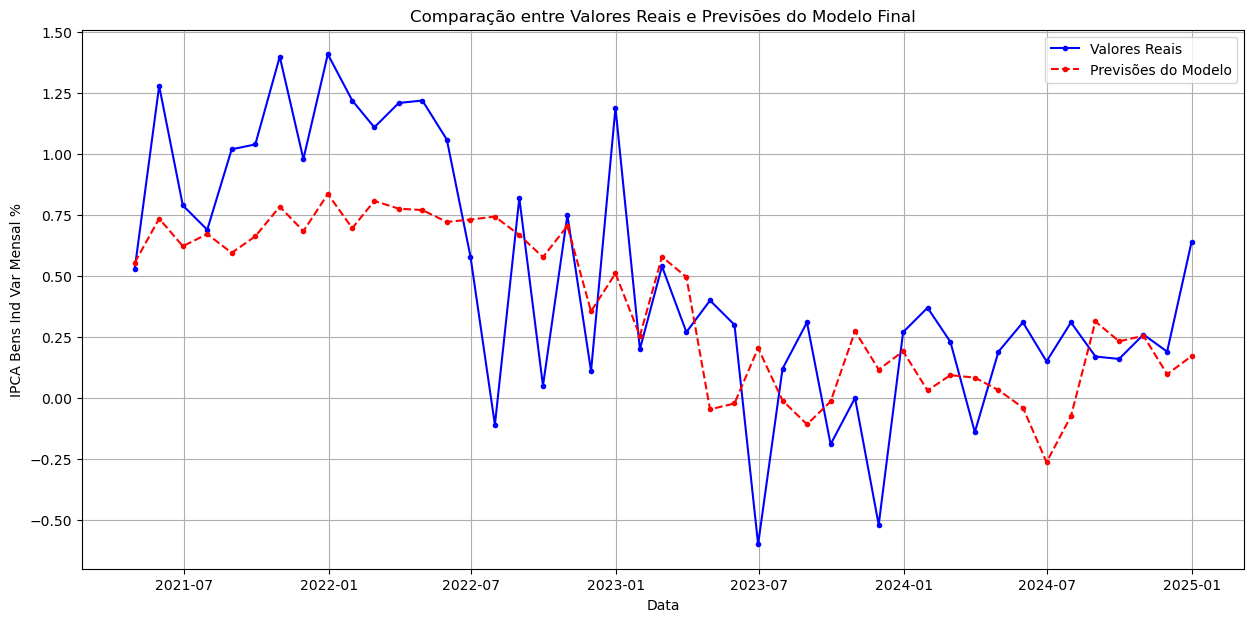

In [67]:
# --- 8. VISUALIZAÇÃO DOS RESULTADOS ---
# Para a devida plotagem do gráfico, é necessário recuperar o índice de tempo original do conjunto de teste.
# O número de previsões será menor que o df_base_teste original por causa da window_size

# Recuperando o índice de tempo correspondente às previsões
indice_plot = df_base_teste.index[window_size:]

# Criação de um DataFrame para facilitar a plotagem
resultados_df = pd.DataFrame({
    'Valores Reais': y_teste_final.flatten(),
    'Previsões do Modelo': y_pred_final.flatten()
}, index=indice_plot)

# Plotar o gráfico
print("\n--- Gráfico de Comparação: Valores Reais vs. Previsões ---")
plt.figure(figsize=(15, 7))
plt.plot(resultados_df['Valores Reais'], label='Valores Reais', color='blue', marker='.', linestyle='-')
plt.plot(resultados_df['Previsões do Modelo'], label='Previsões do Modelo', color='red', marker='.', linestyle='--')
plt.title('Comparação entre Valores Reais e Previsões do Modelo Final')
plt.xlabel('Data')
plt.ylabel('IPCA Bens Ind Var Mensal %')
plt.legend()
plt.grid(True)
plt.show()

## Avaliação Final do Modelo

In [68]:
## Avaliação do modelo final

# --- 9. AVALIAÇÃO FINAL DO MODELO ---
print("\n" + "="*50)
print("--- AVALIAÇÃO FINAL DO MODELO NOS DADOS DE TESTE ---")
print("="*50)
# Usando a sua função de avaliação
aval_modelo(y_teste_final, y_pred_final)


--- AVALIAÇÃO FINAL DO MODELO NOS DADOS DE TESTE ---

Raiz do Erro Quadrático Médio do Modelo: 0.38

Erro Quadrático Médio do Modelo: 0.14

Erro Absoluto Médio NEGATIVO do Modelo: -0.31

Erro Percentual Absoluto Médio: 27436850592700.78

R^2 do Modelo: 0.43


Para Erro Absoluto Médio NEGATIVO, vale a convenção de quanto maior melhor, deve-se escolher o modelo que apresenta maior valor de erro absoluto médio negativo.


Para modelos obtidos por machine learning e redes neurais não se deve considerar o R^2


## Conclusão

O RMSE no conjunto de teste foi de 0.38, enquanto no conjunto de validação foi de 0.245.

O modelo foi treinado majoritariamente com dados de um período (2005-2020) que, apesar de suas próprias crises, tinha uma certa dinâmica. O conjunto de teste (2021-2024), por outro lado, foi dominado por um regime completamente novo e de altíssima volatilidade, influenciado pelos efeitos da pandemia e da guerra na Ucrânia. O modelo aprendeu os padrões do "mundo antigo" e teve dificuldade em aplicá-los perfeitamente ao "mundo novo".

Existe uma profunda quebra estrutural na série da inflação de bens industriais a partir de 2020. Os padrões e as relações entre as variáveis no período pré-pandemia não são mais suficientes para prever com acurácia o período durante pandemia.

Recomendações:

1.	Modelagem por Regimes: Reconhecer que existem diferentes "regimes" (pré-crise e pós-crise) e que talvez sejam necessários modelos diferentes ou adaptativos para cada um.

2.	Retreinamento Contínuo: A solução mais prática em um ambiente de negócios seria implementar um sistema de retreinamento constante. O modelo seria retreinado todo mês ou trimestre com os dados mais recentes para que ele possa se "adaptar" rapidamente às novas realidades econômicas.

3.	Análise Qualitativa: Em cenários de quebra estrutural, a previsão puramente quantitativa perde força. A sua análise seria complementada pelo trabalho de um especialista que pode interpretar o contexto qualitativo dos eventos.

## Avaliação da Performance do Modelo Excluindo os Dados do Regime de Exceção da Base de Teste

A análise do gráfico acima indica que há uma pior performance no período de exceção. A exclusão dos dados do período de exceção pode ser a chave para se entender o verdadeiro potencial do modelo em "tempos normais".

Ao fazer isso, há a separação efetiva da avaliação em duas partes:

* Qual a performance do modelo em "tempos normais"?

* Qual o impacto da crise na performance?


In [69]:
# --- 10. REAVALIAÇÃO DO MODELO EM DIFERENTES REGIMES ECONÔMICOS ---

print("\n" + "="*60)
print("--- REAVALIAÇÃO DO MODELO SEPARANDO PERÍODOS ---")
print("="*60)

# 1. Definir o período de exceção que será analisado à parte.
# O conjunto de teste começa em 2021-04-30.
inicio_excecao = '2021-04-30' 
fim_excecao = '2022-12-31'

# 2. Filtrar o DataFrame de comparação para os dois períodos
df_periodo_excecao = df_comparacao.loc[inicio_excecao:fim_excecao]
df_periodo_normal = df_comparacao.loc[fim_excecao:].iloc[1:] # .iloc[1:] para não incluir o último mês da exceção

# 3. Avaliação no Período de Exceção
#----------------------------------------------------
print(f"\nAnalisando {len(df_periodo_excecao)} pontos do Período de Exceção ({inicio_excecao} a {fim_excecao})")
print("----------------------------------------------------------")

if not df_periodo_excecao.empty:
    aval_modelo(df_periodo_excecao['Real'], df_periodo_excecao['Previsto'])
else:
    print("Não há dados no Período de Exceção para avaliar.")


# 4. Avaliação no Período "Normal"
#----------------------------------------------------
print("\n" + "="*60)
print(f"\nAnalisando {len(df_periodo_normal)} pontos do Período 'Normal' (após {fim_excecao})")
print("----------------------------------------------------------")

if not df_periodo_normal.empty:
    aval_modelo(df_periodo_normal['Real'], df_periodo_normal['Previsto'])
else:
    print("Não há dados no Período 'Normal' para avaliar.")


--- REAVALIAÇÃO DO MODELO SEPARANDO PERÍODOS ---

Analisando 21 pontos do Período de Exceção (2021-04-30 a 2022-12-31)
----------------------------------------------------------

Raiz do Erro Quadrático Médio do Modelo: 0.43

Erro Quadrático Médio do Modelo: 0.19

Erro Absoluto Médio NEGATIVO do Modelo: -0.37

Erro Percentual Absoluto Médio: 1.24

R^2 do Modelo: -0.02


Para Erro Absoluto Médio NEGATIVO, vale a convenção de quanto maior melhor, deve-se escolher o modelo que apresenta maior valor de erro absoluto médio negativo.


Para modelos obtidos por machine learning e redes neurais não se deve considerar o R^2


Analisando 24 pontos do Período 'Normal' (após 2022-12-31)
----------------------------------------------------------

Raiz do Erro Quadrático Médio do Modelo: 0.33

Erro Quadrático Médio do Modelo: 0.11

Erro Absoluto Médio NEGATIVO do Modelo: -0.27

Erro Percentual Absoluto Médio: 51444094861312.88

R^2 do Modelo: -0.39


Para Erro Absoluto Médio NEGATIVO, vale a conven

### Confirmação da Hipótese: O Modelo é Sensível ao Regime Econômico
A análise separada confirmou a hipótese. O desempenho do modelo é drasticamente diferente entre os períodos de "exceção" e "normalidade".

No Período de Exceção (2021-2022): O modelo apresentou um RMSE de 0.43. Este valor reflete a imensa dificuldade em prever um cenário de alta volatilidade, com choques de oferta e pressões inflacionárias sem precedentes.

No Período "Normal" (2023 em diante): O desempenho melhorou substancialmente, com o RMSE caindo para 0.33. Isso representa uma melhora de mais de 23% na precisão do modelo quando o ambiente econômico se torna mais estável e previsível.

Essa separação permite afirmar: sim, o modelo tem um desempenho significativamente melhor em "tempos normais".

#### Interpretação e Conclusão Final

Valor do Modelo em Cenários Estáveis: Um RMSE de 0.33 no período mais recente é um resultado mais útil. Ele está mais próximo do que se encontra na validação cruzada e indica que o modelo tem, de fato, uma boa capacidade de capturar a dinâmica da inflação de bens industriais quando não há choques externos massivos.

Quantificação do Impacto da Crise: Agora se pode medir o "custo" da crise na performance do modelo. A instabilidade do período 2021-2022 degradou a precisão do modelo em cerca de 30% (0.43 vs 0.33). Isso indica que, embora robusto, o modelo tem suas limitações e não pode prever "cisnes negros" perfeitamente – o que é uma característica esperada de praticamente qualquer modelo econométrico.

Reflexão sobre o R² Negativo: O R² negativo em ambos os períodos, embora pareça ruim, diz algo importante sobre a natureza da previsão de séries temporais. Significa que a variância dos erros do modelo é maior que a variância da própria série. Em outras palavras, prever a média do período teria sido "melhor" em termos de R². No entanto, o objetivo do modelo não é prever a média, e sim prever a mudança e a direção. Como se vê no gráfico, o modelo é bom em prever a direção (sobe/desce), mas erra a magnitude, o que o R² penaliza severamente. Isso reforça que, para este problema, o RMSE e o MAE são métricas mais úteis.
